# ポートフォリオ「電力消費予測 深層学習」（仲本夏生）

## 0.0 アウトライン

### 0.1 概要

- この分析では、「電力消費予測 可視化」および「電力消費予測 モデル化」にて、予測モデルを構築した際の課題であった非線形性や複数の周期性のあるデータにおいて、深層学習を用い予測性能を確かめるものである。
- データの可視化や特徴把握は前回までで済んでいるものとして、モデル構築からはじめて行きたい。なお、今回はモデル構築の柔軟性が高い**PyTorch**を用いて実装していく。

**「電力消費予測 モデル化」の結論（抜粋）**
- 今回は、時系列分析モデル、Prophetモデル、決定木系モデルを比較検証し、最も性能が良かったのはProphetモデルに休日フラグと気温の絶対値差分を追加し、さらに残差にLightGBMを適用する手法であった（スタッキングの一部とも解釈可能）。
- この結果の背景として、Prophetモデルがトレンドや季節要因を自動的に捕捉する能力を発揮し、さらにトレンドや季節要因を除いた非線形の残差をLightGBMが効果的に捉えたことが精度向上につながったと考えられる。
- 一方で、今回用いた説明変数（気温と休日）だけでは、電力使用量の全てを予測するには不十分であり、湿度や降水量などの気象要因や、新たな社会的要因を説明変数として加えることで、さらなる改善が期待できる。
- また、現状の手法ではさらなる非線形性の捉え方や長期依存性を十分に扱えていない可能性があるため、次のステップとして以下を試したい。
    - <span style="color: red; ">RNN（再帰型ニューラルネットワーク）</span>や<span style="color: red; ">LSTM（長短期記憶）</span>の導入により、時系列データの長期的な傾向を考慮した予測を行う。
    - 深層学習を活用したモデルを用いることで、複雑な要因間の相互作用をより正確に捉える。

### 0.2 本ポートフォリオの流れ

1. モデル解説と方針
2. データの準備
3. 共通パターンで基本性能を確認
4. RNN パラメータ調整
5. LSTM パラメータ調整
6. GRU パラメータ調整
7. まとめ

## 1.0 モデル解説と方針

- 今回、ニューラルネットワークで電力消費量を予測するために3つのモデルを扱い、その性能を確かめたい。この章では簡単に特徴をまとめていきたい。
- なお、下記以上の詳しい仕組みについては別途記事にまとめた。  
**[Qiita記事：【深層学習】RNN、LSTM、GRUまとめ（仕組み、ちょっとだけ数式）](https://qiita.com/nakamin/items/e96542d4e69feb56bc73)**

### 1.1 RNN（Recurrent Neural Network）

- 状態を扱う有効閉路を持つニューラルネットワークである。
- ここで扱うRNNは閉路上にコンテキスト（文脈）を持つ構造をしており、隠れ層が隠れ層自身に接続して、ある時点での状態を次の状態の入力値として使うことができる。

- 隠れ状態の更新： $h^{(t)} = f(Ux^{(t)} + Wh^{(t-1)})$
    - $h^{(t)}$：時刻 $t$ の隠れ状態
    - $x^{(t)}$：時刻 $t$ の入力
    - $U$：入力から隠れ状態への重み行列
    - $W$：隠れ状態間の重み行列
    - $h^{(t-1)}$：前の隠れ状態
    - $f$：活性化関数（例：tanh）
- 出力の計算： $o^{(t)} = Vh^{(t)}$
    - $ \hat{y}^{(t)} = g(o^{(t)}) $
    - $o^{(t)}$：時刻 $t$ の線形変換後の値
    - $V$：隠れ状態から出力への重み行列
    - $\hat{y}^{(t)}$：時刻 $t$ の出力
    - $g$：出力層で使用する関数（例：softmax、sigmoid）
<center><img src="./imgs/RNN_diagram_with_weights.png" width=400px></center>

- 引用：[CVMLエキスパートガイド RNN 再帰型ニューラルネットワーク](https://cvml-expertguide.net/terms/dl/rnn/#1_RNN_%E5%86%8D%E5%B8%B0%E5%9E%8B%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF_%E3%81%A8%E3%81%AF_%E6%A6%82%E8%A6%81)

- RNNは誤差の逆伝搬計算を行うとき、層をさかのぼるにしたがって誤差が急速に小さくなり学習が進行できないという**勾配消失問題**を抱えている。これは、活性化関数を微分することによって得られる緩やかな傾きや同じ重みを何度も掛け算することによって引き起こされる。
- また、誤差が大きくなりすぎてしまい学習が不安定になる**勾配爆発**という問題も存在する。

### 1.2 LSTM（Long Short-Term Memory）

- 過去の情報を長期記憶しておく記憶セル(memory cell)の導入により、RNNが持っていた「長期記憶の消失」の課題を少し解決したものである。
- RNNの隠れ状態の代わりに，「記憶セルブロック」を再帰する構造で、より「長期の記憶」も、短期の記憶に加えて使用できる。
- 記憶セル内では「全結合層 + 活性化関数」の出力値を重み付け係数として利用することで、他経路の値の調整度を学習するゲート機構(gating mechanism)を利用する。

1. **忘却ゲートの計算（セル状態から，どのくらいの割合だけ情報を廃棄するかを決める）**
- $f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$
   - $f_t$: 忘却ゲート
   - $x_t$: 現在の入力
   - $h_{t-1}$: 前の時刻の隠れ状態
   - $W_f, U_f$: 重み行列
   - $b_f$: バイアス項
   - $\sigma$: シグモイド関数

2. **入力ゲートの計算（どの新情報をセル(長期記憶)に記憶するかを出力）**
- $i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$
   - $i_t$: 入力ゲート

3. **候補セル状態の計算**
- $\tilde{c}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c)$
   - $\tilde{c}_t$: 候補セル状態
   - $\tanh$: 双曲線正接関数（活性化関数）

4. **セル状態の更新（忘却ゲート出力と入力ゲート出力が予測できたあとに，セルの長期記憶を「忘却量 (長期記憶)+入力量(短期記憶の予測値)」の重み付け和として更新）**
- $c_t = f_t \circ c_{t-1} + i_t \circ \tilde{c}_t$
   - $c_t$: 更新されたセル状態
   - $c_{t-1}$: 前の時刻のセル状態
   - $\circ$: 要素ごとの積

5. **出力ゲートの計算（セルから新情報のうち何を出力すべきかの重み係数を決定）**
- $o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$
   - $o_t$: 出力ゲート

6. **隠れ状態の更新**
- $h_t = o_t \circ \tanh(c_t)$
   - $h_t$: 更新された隠れ状態
   - $c_t$: 現在のセル状態

<left><img src="./imgs/LSTM-3gates.png" width=400px></left>

- 引用：[CVMLエキスパートガイド LSTM (Long Short-Term Memory)](https://cvml-expertguide.net/terms/dl/rnn/lstm/)

- セル状態の忘却・記憶の仕組み
1. 入力ゲートで調整した入力値の$i_t \circ \tilde{c}_t$は、長期記憶と短期記憶をどのくらいセルに保持するかの覚える記憶である。
2. 忘却ゲート出力で調整した$f_t \circ \tilde{c}_{t-1}$は、前ステップまで溜め込んでおいた長期記憶を，どのくらいステップ$t$で保持して，残りを破棄するかを調整する忘れる記憶である。
3. 出力ゲートでは、上記2つを加算した新たなセル状態$c_t$をゲートで調整したのち、次のステップ$t - 1$へと受け渡す。

<left><img src="./imgs/LSTM-3gates_process.png" width=400px></left>

- 引用：[CVMLエキスパートガイド LSTM (Long Short-Term Memory)](https://cvml-expertguide.net/terms/dl/rnn/lstm/)

### 1.3 GRU（Gated Reccurent Unit）

- ゲート構造を持つRNNで、前述のLSTMの計算効率化・軽量化を狙った改善版。
- LSTMのゲート機構は，パラメータ数も多く，ユニット内の経路数も複雑で多い。そのせいで逆伝播による学習に，時間が結構かかってしまう難点もあったため、GRUでは、以下に列挙した点でLSTMを改良しLSTMと同等以上の精度を保ちながらも計算効率の向上を達成した。
1. LSTMの「入力ゲート」と「忘却ゲート」を更新ゲートに統合
2. 更新ゲートの補助としてリセットゲートを使用
3. セル状態$c_t$は用いない→(長期記憶も含めて)$h_t$だけに記憶を保持するようにした

※GRUは，省略前のLSTMほどの長期記憶性能は持ち合わせいないので，GRUだと性能が出ない場合には，LSTMのほうが予測性能が良くなる場合もあるため、2者の使い分け意識が重要

1. **リセットゲートの計算（記憶の忘れる割合の調整を担当しており，記憶中のリセットする割合の重みを生成）**
- $r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$
   - $r_t$: リセットゲート
   - $x_t$: 現在の入力
   - $h_{t-1}$: 直前の隠れ状態
   - $W_r, U_r$: 重み行列
   - $b_r$: バイアス項
   - $\sigma$: シグモイド関数

2. **更新ゲートの計算（新たに記憶として覚える割合の調整を担当しており，長期記憶の記憶の更新割合の重みを生成）**
- $z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$
   - $z_t$: 更新ゲート
   - 他の変数はリセットゲートと同様

3. **候補隠れ状態の計算**
- $\tilde{h}_t = \tanh(W_h x_t + r_t \circ (U_h h_{t-1}) + b_h)$
   - $\tilde{h}_t$: 候補隠れ状態
   - $r_t \circ (U_h h_{t-1})$: リセットゲート $r_t$ を用いて過去の情報を調整
   - $\tanh$: 双曲線正接関数（活性化関数）

4. **隠れ状態の更新**
- $h_t = z_t \circ h_{t-1} + (1 - z_t) \circ \tilde{h}_t$
   - $h_t$: 時刻 $t$ の最終的な隠れ状態
   - $z_t$: 更新ゲートが過去と現在の情報を動的に制御
   - $(1 - z_t)$: 候補隠れ状態への寄与

<left><img src="./imgs/GRU-2gates.png" width=400px></left>

- 引用：[CVMLエキスパートガイド GRU (Gated Recurrent Unit, ゲート付き再帰ユニット)](https://cvml-expertguide.net/terms/dl/rnn/gru/)

### 1.4 方針

- まず3つのモデルを基本性能を比較するために共通のパラメータを用いて結果を確認し、そこから精度向上のための方針を練っていくこととする。
- なお、共通パターンのパラメータは下表のとおりとした。このパラメータをベースラインとし、その後にモデル別で精度向上を狙いたい。
- 今回の性能評価としては、**決定係数**と、**平均平方根誤差**を前回のポートフォリオに引き続き採用したい。
- また、timeモジュールで実行時間を計測して、処理能力や効率性も評価していきたい（PCの実行環境によって処理時間が大きく異なってくるため何回か実行したうち最短の時間を精度表には記載）。
    - CPU times: プログラムが実行されている間にCPUが処理に費やした時間を指す。
    - Wall time: プログラムの実行開始から終了までの実際の経過時間を指す。これはI/O操作や並列処理による待機時間を含む。

| パラメータ         | 意味                 | 値        | 補足                                                                                 |
|-------------------|----------------------|-----------|--------------------------------------------------------------------------------------|
| batch_size        | バッチサイズ          | 128       | データを適切な量で分割し、学習の効率性を確保するための標準設定。                        |
| learning_rate     | 学習率               | 0.001     | 学習の安定性と収束のバランスを保つための標準設定。                                    |
| layers            | 層の数               | 1         | 1層からスタートして複雑さの増加が性能に与える影響を確認                      |
| hidden_size       | 隠れユニット数        | 128       | モデルの表現力と計算コストのバランスを取るための標準設定                             |
| dropout           | ドロップアウト率      | 0.0       | 1層の場合は不要。層を追加する際にドロップアウトを用いることで過学習を防ぐ            |
| sequence_length   | シーケンスの長さ      | 24        | 次の24時間（1日）を予測するためのウィンドウサイズとして設定                          |
| num_epochs        | エポック数            | 20        | early stopping（学習の打ち切り）を導入し、適切な時点で学習を終了できるよう設定       |
| patience          | EarlyStoppingの閾値 | 5         | 5エポック連続で改善が見られない場合に学習を終了し、過学習を防ぐ                      |
| loss_function     | 損失関数              | MSELoss   | 平均二乗誤差（Mean Squared Error）を使用して予測誤差を評価する。                       |
| optimizer         | 最適化アルゴリズム    | Adam      | 勾配降下法の改良版。学習率を動的に調整し、効率的な最適化を行う。                       |

## 2.0 データの準備

- データは「電力消費予測 モデル化」において扱った電力消費量データと同一のものを使い、それを深層学習用に加工していく。
- データ取得元
  - 東京エリアの1時間ごとの電力消費量データ（2016年～2023年）。出典：[東京電力パワーグリッド でんき予報](https://www.tepco.co.jp/forecast/html/download-j.html)
  - 1時間ごとの平均気温データ（同上）。出典：[国土交通省 気象庁 過去の気象データ・ダウンロード](https://www.data.jma.go.jp/risk/obsdl/index.php#)
- 前回と同じく、2022年までのデータで訓練を行い、2023年のデータでその予測性能を確認する。
  - 学習データ：2016年4月～2022年12月（59,184行）。
  - テストデータ：2023年1月～12月（8,760行）。
- 加工前のデータセットは以下とおり。なお、temprature_absとis_holidayについては前回のポートフォリオ内で新しく作成した説明変数となっている。

| 項目              | 種類         | 単位                  | 説明                                                                                   |
|-------------------|--------------|-----------------------|---------------------------------------------------------------------------------------|
| 目的変数 (y)      | 量的変数     | 10MW                  | 電力消費量                                                                             |
| 説明変数 (x)      |              |                       |                                                                                       |
| - temperature     | 量的変数     | 摂氏 (°C)             | 気温                                                                                   |
| - temperature_abs | 量的変数     | 摂氏 (°C)             | 電力消費量が減少する閾値18.2度を基準とした絶対値差分                                     |
| - is_holiday      | 質的変数     | 1: 休日, 0: 平日      | 土日祝日および祝日の振替休日が「1」、平日が「0」としてフラグ付けされた変数                  |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = "Meiryo"
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("./data/data.csv")
df = df.ffill()
df

,DATETIME,10MW,temperature,temperature_abs,is_holiday
0,2016/4/1 0:00,2555,14.5,3.6,0
1,2016/4/1 1:00,2433,13.3,4.8,0
2,2016/4/1 2:00,2393,13.8,4.3,0
3,2016/4/1 3:00,2375,13.0,5.1,0
4,2016/4/1 4:00,2390,12.2,5.9,0
...,...,...,...,...,...
67939,2023/12/31 19:00,2919,9.6,8.5,1
67940,2023/12/31 20:00,2845,11.4,6.7,1
67941,2023/12/31 21:00,2754,11.0,7.1,1
67942,2023/12/31 22:00,2647,9.5,8.6,1


In [3]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [4]:
import datetime as dt
df["year"] = df['DATETIME'].dt.year
df["month"] = df['DATETIME'].dt.month
df["hour"] = df['DATETIME'].dt.hour

In [5]:
train_df = df[(df['DATETIME'] >= dt.datetime(2016,4,1)) & (df['DATETIME'] < dt.datetime(2022,12,31))].reset_index(drop=True)
test_df = df[(df['DATETIME'] >= dt.datetime(2023,1,1)) & (df['DATETIME'] < dt.datetime(2023,12,31))].reset_index(drop=True)

In [6]:
train_df = train_df.drop(columns='DATETIME')
test_df = test_df.drop(columns='DATETIME')

In [7]:
y_train = train_df['10MW']
y_test = test_df['10MW']
X_train = train_df.drop(columns='10MW')
X_test = test_df.drop(columns='10MW')

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(59160, 6) (59160,) (8736, 6) (8736,)


In [9]:
# MinMaxScalerを使って特徴量とターゲットを 0〜1 にスケーリング
from sklearn.preprocessing import MinMaxScaler

# MinMaxScalerを適用
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# X_train, X_test のスケーリング
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# y_train, y_test のスケーリング (1次元 → 2次元にreshape)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# LSTM/RNNモデルの学習や予測では、y_train_scaled が 2次元 (n_samples, 1) のまま使えるので、flattenは不要 

In [10]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (59160, 6)
X_test_scaled shape: (8736, 6)
y_train_scaled shape: (59160, 1)
y_test_scaled shape: (8736, 1)


In [11]:
data_train = torch.tensor(X_train_scaled, dtype=torch.float32)
data_test = torch.tensor(X_test_scaled, dtype=torch.float32)
targets_train = torch.tensor(y_train_scaled, dtype=torch.float32)
targets_test = torch.tensor(y_test_scaled, dtype=torch.float32)

In [12]:
# モデルに適した形状に変換する
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length] # モデルの入力
        label = targets[i+sequence_length] # 予測すべき次の値
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# 過去の一定期間（24時間分）のデータを1つの入力シーケンとしてまとめる
sequence_length = 24

# シーケンスデータ作成
train_sequences, train_labels = create_sequences(data_train, targets_train, sequence_length)
test_sequences, test_labels = create_sequences(data_test, targets_test, sequence_length)

print(train_sequences.shape)  # (n_samples, sequence_length, num_features)
print(train_labels.shape)     # (n_samples, 1)

torch.Size([59136, 24, 6])
torch.Size([59136, 1])


## 3.0 共通パターンで基本性能を確認

- この章では、前述した共通のパラメータ設定で基本性能を確認していく。

### 3.1 RNN

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import random

# モデル定義
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.dropout = nn.Dropout(dropout) 出力層にdropoutを適用する場合
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) # 各時刻での隠れ層の出力（batch_size, seq_length, hidden_size）と最後の時刻の隠れ状態（使用しない）を出力
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.trigger_times = 0

    def check(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.trigger_times = 0
            return False  # Early Stoppingしない
        else:
            self.trigger_times += 1
            return self.trigger_times >= self.patience  # 改善が見られなければTrue

# 訓練処理
def train_one_epoch(model, dataloader, criterion, optimizer, scaler_y):
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_X, batch_y in dataloader: # 入力データのバッチと対応するラベル（ターゲット値）のバッチを取得
        outputs = model(batch_X) # モデルで予測
        loss = criterion(outputs, batch_y) # 出力とラベルの損失を計算
        # パラメータに対する勾配を初期化（デフォルトで各バッチの計算で勾配が累積される）
        optimizer.zero_grad()
        # 逆伝播を実行し、モデルのすべてのパラメータに対する損失の勾配を計算
        loss.backward()
        # 学習率を用いてoptimizer（torch.optim.Adam）が計算された勾配を使用してパラメータを更新
        optimizer.step()
        total_loss += loss.item() # 各バッチの損失を累積

        all_predictions.append(outputs.detach())
        all_targets.append(batch_y.detach())

    predictions = scaler_y.inverse_transform(torch.cat(all_predictions).numpy())
    targets = scaler_y.inverse_transform(torch.cat(all_targets).numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return total_loss / len(dataloader), rmse, predictions, targets # エポック全体の平均損失（loss）を計算


# 検証処理
def evaluate(model, dataloader, criterion, scaler_y):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            outputs = model(batch_X) # モデルの予測値を計算
            loss = criterion(outputs, batch_y)
            # 検証（evaluate）ではモデルの性能を確認するだけでパラメータの更新を行わない
            total_loss += loss.item()
            all_predictions.append(outputs)
            all_targets.append(batch_y)

    predictions = scaler_y.inverse_transform(torch.cat(all_predictions).numpy()) # すべてのバッチの予測値を1つのテンソルにしてからスケールを元に戻sす
    targets = scaler_y.inverse_transform(torch.cat(all_targets).numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return total_loss / len(dataloader), rmse, predictions, targets


# 訓練と検証の統合処理
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience):
    # 学習データ (train_sequences と train_labels) を管理しバッチサイズごとに分割、テストデータ (test_sequences と test_labels) を管理しモデルの評価時に使用
    train_losses = []
    train_rmse = []
    test_losses = []
    test_rmse = []
    early_stopping = EarlyStopping(patience=patience)
    final_train_predictions = None
    final_train_targets = None

    for epoch in range(num_epochs):
        # train_one_epochの呼び出し（戻り値は学習データの平均損失、学習データのRMSE、学習データの予測値（全バッチ）、学習データの実測値（全バッチ））
        train_loss, train_rmse_value, train_predictions, train_targets = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler_y
        )
        # evaluateの呼び出し（戻り値は検証データの平均損失、検証データのRMSE、検証データの予測値（全バッチ）、検証データの実測値（全バッチ））
        test_loss, test_rmse_value, test_predictions, test_targets = evaluate(
            model, test_loader, criterion, scaler_y
        )

        train_losses.append(train_loss)
        train_rmse.append(train_rmse_value)
        test_losses.append(test_loss)
        test_rmse.append(test_rmse_value)

        # 最終エポックの予測値と実測値を記録
        final_train_predictions = train_predictions
        final_train_targets = train_targets

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse_value:.4f}, Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse_value:.4f}")

        if early_stopping.check(test_loss):
            print("Early stopping triggered")
            break

    return train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, final_train_predictions, final_train_targets

# プロット処理
def plot_curves(train_losses, test_losses, train_rmse, test_rmse):
    plt.figure(figsize=(10, 5))

    # 損失関数のプロット
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# プロット処理
def plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions):
    plot_curves(train_losses, test_losses, train_rmse, test_rmse)
    r2 = r2_score(test_targets, test_predictions)
    rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
    print("R2 Score:", r2)
    print("RMSE:", rmse)
    return r2, rmse

# モデル初期化
def initialize_RNNModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout=0.0):
    input_size = X_train_scaled.shape[1]
    model = RNNModel(input_size, hidden_size, 1, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

# random seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # PyTorchのCuDNNライブラリ（NVIDIA GPU専用）での動作を制御する設定
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

Epoch 1/20, Train Loss: 0.0086, Train RMSE: 376.1825, Test Loss: 0.0042, Test RMSE: 259.8656
Epoch 2/20, Train Loss: 0.0045, Train RMSE: 272.1881, Test Loss: 0.0054, Test RMSE: 294.6773
Epoch 3/20, Train Loss: 0.0036, Train RMSE: 243.0817, Test Loss: 0.0045, Test RMSE: 270.5560
Epoch 4/20, Train Loss: 0.0034, Train RMSE: 235.0747, Test Loss: 0.0054, Test RMSE: 291.5882
Epoch 5/20, Train Loss: 0.0032, Train RMSE: 228.8452, Test Loss: 0.0036, Test RMSE: 239.1965
Epoch 6/20, Train Loss: 0.0031, Train RMSE: 224.9047, Test Loss: 0.0043, Test RMSE: 265.9481
Epoch 7/20, Train Loss: 0.0030, Train RMSE: 221.1037, Test Loss: 0.0049, Test RMSE: 279.9355
Epoch 8/20, Train Loss: 0.0029, Train RMSE: 218.3998, Test Loss: 0.0038, Test RMSE: 249.3375
Epoch 9/20, Train Loss: 0.0029, Train RMSE: 216.9135, Test Loss: 0.0047, Test RMSE: 277.2945
Epoch 10/20, Train Loss: 0.0028, Train RMSE: 213.7960, Test Loss: 0.0035, Test RMSE: 240.6157
Epoch 11/20, Train Loss: 0.0027, Train RMSE: 212.4215, Test Loss: 0.0

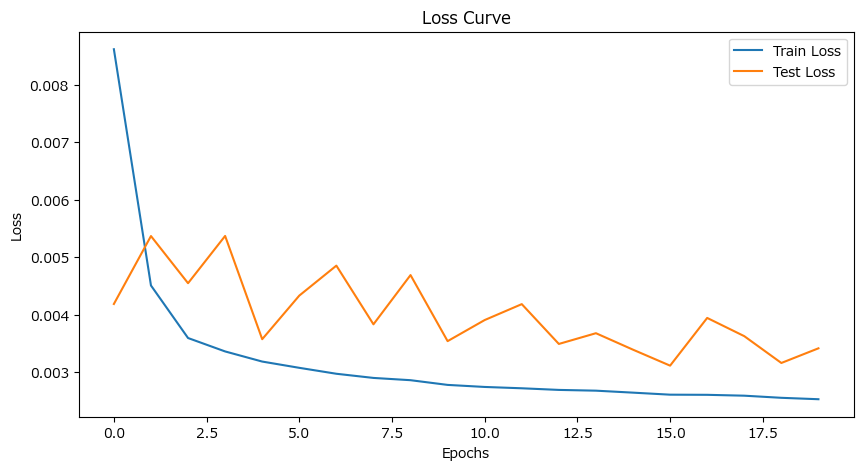

R2 Score: 0.8888226241361806
RMSE: 237.65305
CPU times: total: 7min 28s
Wall time: 5min 41s


In [14]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.0
    patience = 5

    model, criterion, optimizer = initialize_RNNModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    test_predictions = np.array(test_predictions).reshape(-1)
    test_targets = np.array(test_targets).reshape(-1)
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 3.2 LSTM

In [15]:
# モデル定義
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.dropout = nn.Dropout(dropout) 出力層にdropoutを適用する場合
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

# モデル初期化
def initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout=0.0):
    input_size = X_train_scaled.shape[1]
    model = LSTMModel(input_size, hidden_size, 1, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

Epoch 1/20, Train Loss: 0.0081, Train RMSE: 364.5164, Test Loss: 0.0055, Test RMSE: 296.6481
Epoch 2/20, Train Loss: 0.0031, Train RMSE: 227.1179, Test Loss: 0.0034, Test RMSE: 234.8177
Epoch 3/20, Train Loss: 0.0028, Train RMSE: 215.4496, Test Loss: 0.0028, Test RMSE: 216.5516
Epoch 4/20, Train Loss: 0.0027, Train RMSE: 210.3234, Test Loss: 0.0028, Test RMSE: 215.4649
Epoch 5/20, Train Loss: 0.0026, Train RMSE: 205.1724, Test Loss: 0.0039, Test RMSE: 251.8018
Epoch 6/20, Train Loss: 0.0025, Train RMSE: 203.2875, Test Loss: 0.0030, Test RMSE: 221.3054
Epoch 7/20, Train Loss: 0.0024, Train RMSE: 199.0732, Test Loss: 0.0031, Test RMSE: 222.8495
Epoch 8/20, Train Loss: 0.0024, Train RMSE: 198.9628, Test Loss: 0.0034, Test RMSE: 233.9586
Epoch 9/20, Train Loss: 0.0023, Train RMSE: 196.4582, Test Loss: 0.0030, Test RMSE: 218.6957
Early stopping triggered


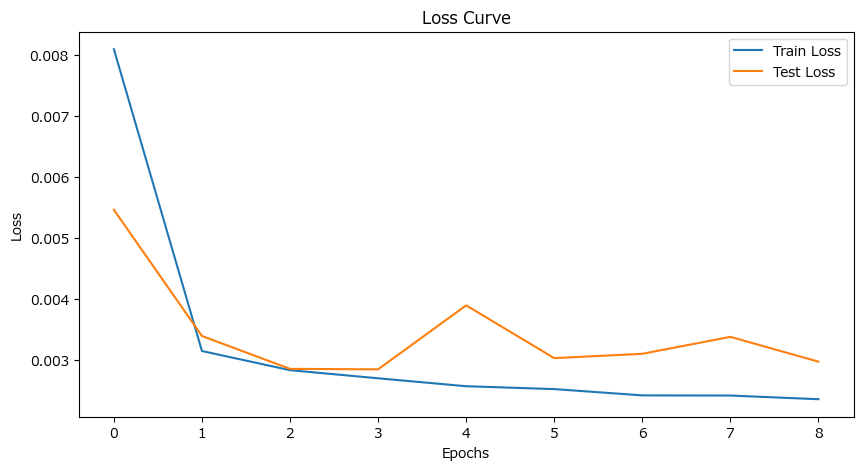

R2 Score: 0.9058522196312824
RMSE: 218.6957
CPU times: total: 9min 49s
Wall time: 4min 52s


In [16]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    dropout = 0.0
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5

    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 3.3 GRU

In [17]:
# モデル定義
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.dropout = nn.Dropout(dropout) 出力層にdropoutを適用する場合
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

# モデル初期化
def initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout=0.0):
    input_size = X_train_scaled.shape[1]
    model = GRUModel(input_size, hidden_size, 1, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

Epoch 1/20, Train Loss: 0.0086, Train RMSE: 375.7509, Test Loss: 0.0057, Test RMSE: 304.6505
Epoch 2/20, Train Loss: 0.0036, Train RMSE: 244.3691, Test Loss: 0.0046, Test RMSE: 273.0483
Epoch 3/20, Train Loss: 0.0028, Train RMSE: 215.3815, Test Loss: 0.0040, Test RMSE: 255.3200
Epoch 4/20, Train Loss: 0.0027, Train RMSE: 208.7228, Test Loss: 0.0034, Test RMSE: 234.0128
Epoch 5/20, Train Loss: 0.0025, Train RMSE: 204.3533, Test Loss: 0.0036, Test RMSE: 243.1964
Epoch 6/20, Train Loss: 0.0025, Train RMSE: 202.1166, Test Loss: 0.0029, Test RMSE: 216.4569
Epoch 7/20, Train Loss: 0.0024, Train RMSE: 200.2437, Test Loss: 0.0033, Test RMSE: 232.0983
Epoch 8/20, Train Loss: 0.0024, Train RMSE: 198.5076, Test Loss: 0.0035, Test RMSE: 238.6386
Epoch 9/20, Train Loss: 0.0024, Train RMSE: 196.9390, Test Loss: 0.0032, Test RMSE: 229.0930
Epoch 10/20, Train Loss: 0.0024, Train RMSE: 196.7440, Test Loss: 0.0030, Test RMSE: 221.2092
Epoch 11/20, Train Loss: 0.0023, Train RMSE: 194.8551, Test Loss: 0.0

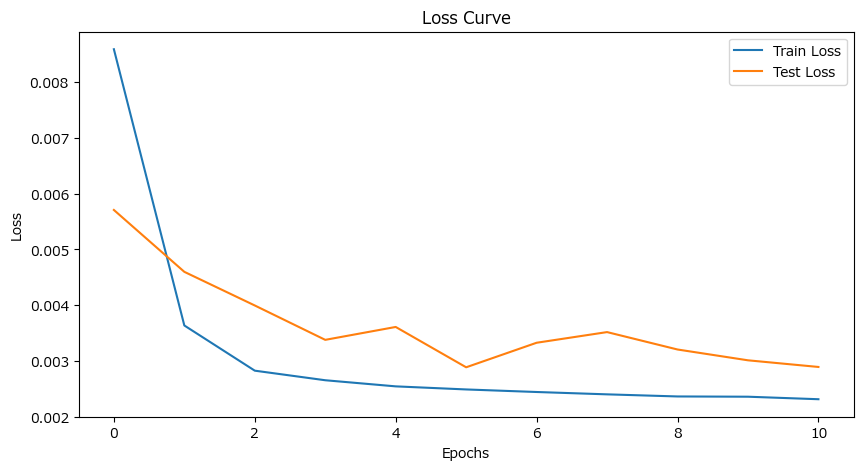

R2 Score: 0.9084967709260989
RMSE: 215.6023
CPU times: total: 8min 5s
Wall time: 7min 51s


In [18]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.0
    patience = 5

    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 3.4 結果のまとめ

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 1   | RNN   | デフォルト設定                              |                   | 0.8888    | 237.65305 | 3分5秒           |                              |
| 2   | LSTM        | デフォルト設定                              |                   | 0.9059    | 218.6957  | 2分8秒          |                              |
| 3   | GRU         | デフォルト設定                              |                   | 0.9085    | 215.6023  | 3分47秒         |                              |

- ベースラインとしては、GRUが一番性能が良かった。ここからパラメータを調整することによる精度向上を確かめていきたい。

## 4.0 RNN パラメータ調整

- この章では、RNNのパラメータ調整を行う。
- 特徴として、シンプルな構造で計算コストが低いが、長期依存関係を学習する能力が限られていることが挙げられる。
- このモデルでのパラメータ調整内容としては以下の3通りを挙げたい。
1. `num_layers`を増やす（1→2層）
    - 単層RNNでは複雑な非線形関係を十分に学習できない場合があるため、層を増やすことでモデルが学習できる表現力を向上させたい
2. `hidden_size`を減らす（128→64）
    - 今回のデータは周期性が強く特徴量も少ないため、隠れ層の数を減らすことによる過学習の防止や計算コストの削減を狙いたい
3. 上記の両方の施策を試す

### 補足：dropout0.5について

- なお、今回層を増やすにあたって過学習を防止するためにdropoutを設定する。
    - dropout法とは学習時に一度学習したノードをランダムに無効化し過学習を防止するもの
- 設定する値については検証曲線を描いて適切な値を見つけたい（実行にあたっては3時間ほど要してしまったのでここでは結果だけを表示する）。

In [19]:
"""
class RNNDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RNNDropout, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

def train_and_evaluate(dropout_rate, train_loader, test_loader, input_size, hidden_size, num_layers, output_size, epochs=20, lr=0.001):
    # モデルの初期化
    model = RNNDropout(input_size, hidden_size, output_size, num_layers, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss = 0
    test_loss = 0
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_loader)
        
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, targets = batch
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_test_loss += loss.item()
            test_loss = epoch_test_loss / len(test_loader)
    return train_loss, test_loss

def plot_dropout(train_loader, test_loader, input_size, hidden_size, num_layers, output_size):
    dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    train_losses = []
    test_losses = []
    for rate in dropout_rates:
        print(f"Training with dropout rate: {rate}")
        train_loss, test_loss = train_and_evaluate(
            dropout_rate=rate,
            train_loader=train_loader,
            test_loader=test_loader,
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=output_size
        )
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    # プロット
    plt.figure(figsize=(10, 5))
    plt.plot(dropout_rates, train_losses, label="Train Loss", marker='o')
    plt.plot(dropout_rates, test_losses, label="Test Loss", marker='o')
    plt.xlabel("Dropout Rate")
    plt.ylabel("Loss")
    plt.title("Effect of Dropout Rate on Model Performance")
    plt.legend()
    plt.grid(True)
    plt.show()
"""

'\nclass RNNDropout(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):\n        super(RNNDropout, self).__init__()\n        self.rnn = nn.RNN(\n            input_size=input_size,\n            hidden_size=hidden_size,\n            num_layers=num_layers,\n            batch_first=True,\n            dropout=dropout\n        )\n        self.fc = nn.Linear(hidden_size, output_size)\n\n    def forward(self, x):\n        out, _ = self.rnn(x)\n        out = self.fc(out[:, -1, :])\n        return out\n\ndef train_and_evaluate(dropout_rate, train_loader, test_loader, input_size, hidden_size, num_layers, output_size, epochs=20, lr=0.001):\n    # モデルの初期化\n    model = RNNDropout(input_size, hidden_size, output_size, num_layers, dropout_rate)\n    criterion = nn.MSELoss()\n    optimizer = optim.Adam(model.parameters(), lr=lr)\n    train_loss = 0\n    test_loss = 0\n    for epoch in range(epochs):\n        model.train()\n        epoch_train_loss = 0\n      

In [20]:
"""
train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=24, shuffle=True)
test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=24, shuffle=False)

input_size = X_train_scaled.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1

plot_dropout(
    train_loader=train_loader,
    test_loader=test_loader,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
)
"""

'\ntrain_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=24, shuffle=True)\ntest_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=24, shuffle=False)\n\ninput_size = X_train_scaled.shape[1]\nhidden_size = 128\nnum_layers = 2\noutput_size = 1\n\nplot_dropout(\n    train_loader=train_loader,\n    test_loader=test_loader,\n    input_size=input_size,\n    hidden_size=hidden_size,\n    num_layers=num_layers,\n    output_size=output_size\n)\n'

<center><img src="./imgs/Effect of Dropout Rate on Model Performance.png" width=1000px></center>

- Train loss
    - 訓練データに関しては安定した学習がされているが、0.6でLossが上昇する様子が見られる
- Test loss
    - 0.2～0.4の値で過学習が起こり訓練データとの差が開くのに対して、0.5で安定する様子が見られる
- よって、今回はdropoutを0.5と設定（50%の確率でランダムにノードを無効化）したい。

### num_layersを増やす（1→2層） + dropout0.5を追加

Epoch 1/20, Train Loss: 0.0082, Train RMSE: 367.7522, Test Loss: 0.0046, Test RMSE: 272.7202
Epoch 2/20, Train Loss: 0.0046, Train RMSE: 274.2124, Test Loss: 0.0045, Test RMSE: 272.1547
Epoch 3/20, Train Loss: 0.0037, Train RMSE: 246.5861, Test Loss: 0.0035, Test RMSE: 236.5500
Epoch 4/20, Train Loss: 0.0034, Train RMSE: 236.6369, Test Loss: 0.0043, Test RMSE: 265.6387
Epoch 5/20, Train Loss: 0.0033, Train RMSE: 232.2182, Test Loss: 0.0035, Test RMSE: 238.8590
Epoch 6/20, Train Loss: 0.0032, Train RMSE: 230.1138, Test Loss: 0.0032, Test RMSE: 229.3923
Epoch 7/20, Train Loss: 0.0031, Train RMSE: 226.8052, Test Loss: 0.0045, Test RMSE: 269.0435
Epoch 8/20, Train Loss: 0.0030, Train RMSE: 223.6158, Test Loss: 0.0042, Test RMSE: 261.0030
Epoch 9/20, Train Loss: 0.0030, Train RMSE: 220.8537, Test Loss: 0.0034, Test RMSE: 235.2139
Epoch 10/20, Train Loss: 0.0029, Train RMSE: 218.3218, Test Loss: 0.0035, Test RMSE: 238.4591
Epoch 11/20, Train Loss: 0.0029, Train RMSE: 217.8401, Test Loss: 0.0

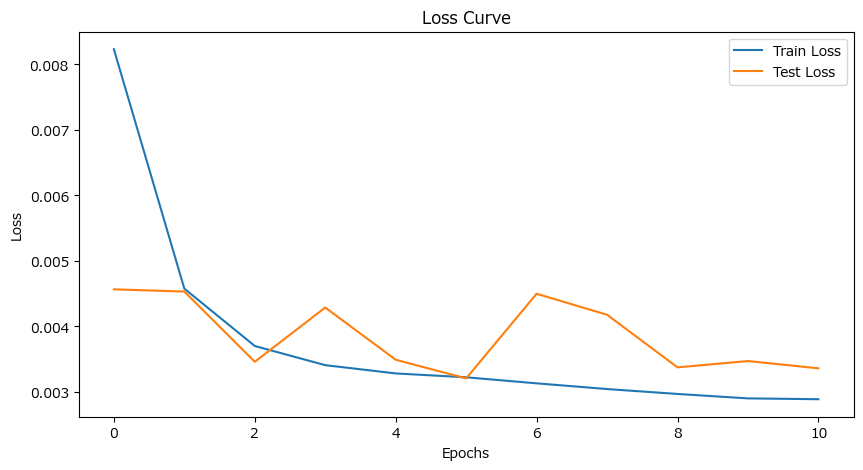

R2 Score: 0.8925810922630015
RMSE: 233.60146
CPU times: total: 10min 11s
Wall time: 9min 24s


In [21]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 2 # 変更
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.5 # 変更
    patience = 5

    model, criterion, optimizer = initialize_RNNModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    test_predictions = np.array(test_predictions).reshape(-1)
    test_targets = np.array(test_targets).reshape(-1)
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### hidden_sizeを減らす（128→64）

Epoch 1/20, Train Loss: 0.0081, Train RMSE: 364.3616, Test Loss: 0.0042, Test RMSE: 262.9663
Epoch 2/20, Train Loss: 0.0043, Train RMSE: 266.2759, Test Loss: 0.0049, Test RMSE: 283.0123
Epoch 3/20, Train Loss: 0.0037, Train RMSE: 247.3389, Test Loss: 0.0038, Test RMSE: 248.6503
Epoch 4/20, Train Loss: 0.0033, Train RMSE: 233.9672, Test Loss: 0.0042, Test RMSE: 261.2132
Epoch 5/20, Train Loss: 0.0031, Train RMSE: 226.4714, Test Loss: 0.0043, Test RMSE: 264.7279
Epoch 6/20, Train Loss: 0.0030, Train RMSE: 220.8942, Test Loss: 0.0039, Test RMSE: 250.8656
Epoch 7/20, Train Loss: 0.0029, Train RMSE: 218.3641, Test Loss: 0.0046, Test RMSE: 272.6236
Epoch 8/20, Train Loss: 0.0028, Train RMSE: 215.6983, Test Loss: 0.0040, Test RMSE: 255.2855
Early stopping triggered


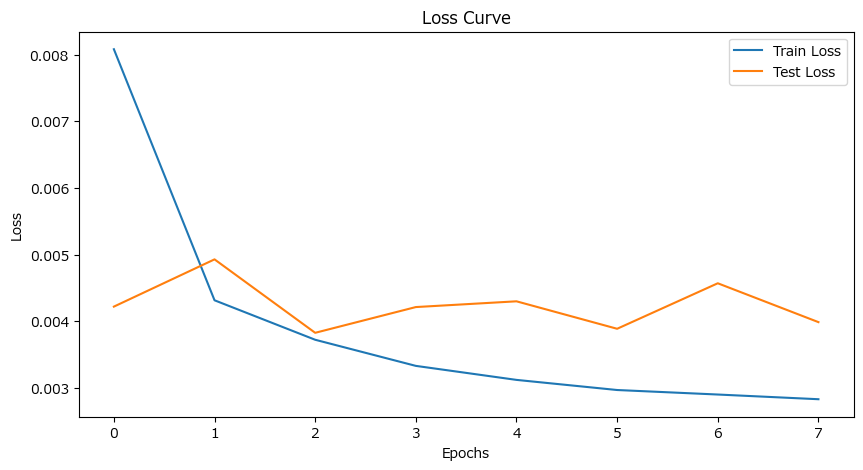

R2 Score: 0.8717132237991216
RMSE: 255.28548
CPU times: total: 3min 39s
Wall time: 3min 32s


In [22]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 64 # 変更
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_RNNModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    test_predictions = np.array(test_predictions).reshape(-1)
    test_targets = np.array(test_targets).reshape(-1)
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### num_layersを増やす（1→2層） + dropout0.5を追加 + hidden_sizeを減らす（128→64）

Epoch 1/20, Train Loss: 0.0115, Train RMSE: 433.8849, Test Loss: 0.0053, Test RMSE: 289.8760
Epoch 2/20, Train Loss: 0.0055, Train RMSE: 300.9934, Test Loss: 0.0051, Test RMSE: 286.2183
Epoch 3/20, Train Loss: 0.0049, Train RMSE: 284.9914, Test Loss: 0.0063, Test RMSE: 318.5632
Epoch 4/20, Train Loss: 0.0039, Train RMSE: 254.2672, Test Loss: 0.0072, Test RMSE: 343.4532
Epoch 5/20, Train Loss: 0.0036, Train RMSE: 242.4765, Test Loss: 0.0030, Test RMSE: 221.8365
Epoch 6/20, Train Loss: 0.0035, Train RMSE: 238.2695, Test Loss: 0.0054, Test RMSE: 294.9897
Epoch 7/20, Train Loss: 0.0033, Train RMSE: 231.6293, Test Loss: 0.0033, Test RMSE: 231.4639
Epoch 8/20, Train Loss: 0.0032, Train RMSE: 231.0024, Test Loss: 0.0053, Test RMSE: 291.2328
Epoch 9/20, Train Loss: 0.0031, Train RMSE: 227.3339, Test Loss: 0.0031, Test RMSE: 222.8008
Epoch 10/20, Train Loss: 0.0031, Train RMSE: 224.3215, Test Loss: 0.0044, Test RMSE: 267.2487
Early stopping triggered


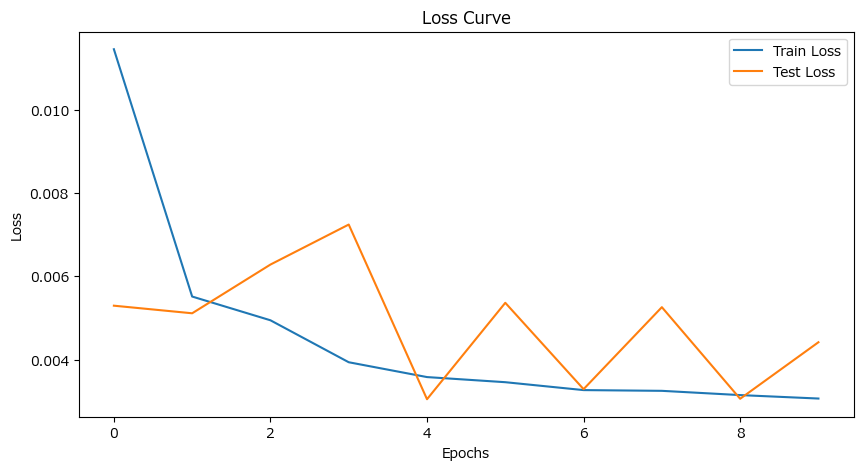

R2 Score: 0.8594079395376435
RMSE: 267.24866
CPU times: total: 9min 6s
Wall time: 8min 42s


In [23]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 64 # 変更
    num_layers = 2 # 変更
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.5 # 変更
    patience = 5
    
    model, criterion, optimizer = initialize_RNNModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    test_predictions = np.array(test_predictions).reshape(-1)
    test_targets = np.array(test_targets).reshape(-1)
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 結果

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 1   | RNN   | デフォルト設定                              |                   | 0.8888    | 237.65305 | 3分5秒           |                              |
| 4   | RNN   | RNN層を2層に変更（1→2層）                   | 中間層            | 0.8926    | 233.60146 | 9分24秒          |                              |
| 4   | RNN   | RNN層を2層に変更（1→2層）                   | 出力層            | 0.8835    | 243.29239 | 3分5秒            |                              |
| 5   | RNN   | 隠れユニット数を128→64に変更                |                   | 0.8717    | 255.28548 | 3分23秒           |                              |
| 6   | RNN   | RNN層2層、隠れユニット数64に変更            | 中間層            | 0.8594    | 267.24866 | 2分33秒          |                              |
| 6   | RNN   | RNN層2層、隠れユニット数64に変更            | 出力層            | 0.8960    | 229.85461 | 3分7秒          | RNNの中で最良の性能     |

- RNNでは、 出力層にドロップアウトを適用すること、隠れユニット数64にすることがベストであり、複雑さを上げることが性能の向上には繫がっていない。
- なお、今回はdropoutの適用を中間層と出力層の両方試行しているため、精度表に出力層に適用した場合の結果も記載している（コードと出力結果自体は中間層に適用したもの）。

## 5.0 LSTM パラメータ調整

- この章では、LSTMのパラメータ調整を行う。
- モデルの特徴として、セル状態とゲート機構により長期的な依存関係を学習できるが、計算コストが高く過学習のリスクがある。
- このモデルでのパラメータ調整内容としては以下の3通りを挙げたい。
1. `num_layers`を増やす（1→2層）
    - 多層LSTMは複雑なパターンを学習する際に性能が向上することが多い
    - また、層数が増えるので過学習を防ぐために`dropout`は0.5に設定する
2. `hidden_size`を増やす（128→256）
    - 1と同様に、複雑にすることで性能向上を狙いたい
3. 上記の両方の施策を試す

### num_layersを増やす（1→2層） + dropout0.5を追加

Epoch 1/20, Train Loss: 0.0078, Train RMSE: 358.4065, Test Loss: 0.0033, Test RMSE: 233.8667
Epoch 2/20, Train Loss: 0.0034, Train RMSE: 235.3406, Test Loss: 0.0038, Test RMSE: 249.8586
Epoch 3/20, Train Loss: 0.0030, Train RMSE: 221.7967, Test Loss: 0.0036, Test RMSE: 240.8246
Epoch 4/20, Train Loss: 0.0029, Train RMSE: 216.7578, Test Loss: 0.0029, Test RMSE: 218.4938
Epoch 5/20, Train Loss: 0.0028, Train RMSE: 212.7756, Test Loss: 0.0034, Test RMSE: 234.3026
Epoch 6/20, Train Loss: 0.0027, Train RMSE: 209.8481, Test Loss: 0.0031, Test RMSE: 223.3300
Epoch 7/20, Train Loss: 0.0026, Train RMSE: 207.1496, Test Loss: 0.0031, Test RMSE: 225.6423
Epoch 8/20, Train Loss: 0.0026, Train RMSE: 206.3894, Test Loss: 0.0031, Test RMSE: 224.8589
Epoch 9/20, Train Loss: 0.0025, Train RMSE: 202.8474, Test Loss: 0.0035, Test RMSE: 240.2993
Early stopping triggered


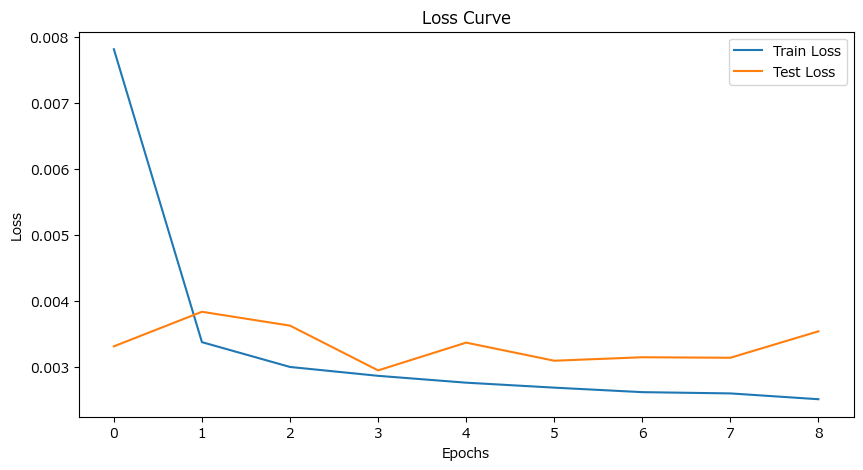

R2 Score: 0.8863329218659166
RMSE: 240.29932
CPU times: total: 25min 22s
Wall time: 7min 49s


In [24]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 2 # 変更
    dropout = 0.5 # 変更
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5
    
    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### hidden_sizeを増やす（128→256）

Epoch 1/20, Train Loss: 0.0073, Train RMSE: 345.9601, Test Loss: 0.0057, Test RMSE: 302.8741
Epoch 2/20, Train Loss: 0.0030, Train RMSE: 223.4124, Test Loss: 0.0039, Test RMSE: 251.3694
Epoch 3/20, Train Loss: 0.0028, Train RMSE: 213.7425, Test Loss: 0.0036, Test RMSE: 242.4632
Epoch 4/20, Train Loss: 0.0026, Train RMSE: 208.4615, Test Loss: 0.0031, Test RMSE: 222.0276
Epoch 5/20, Train Loss: 0.0026, Train RMSE: 205.3253, Test Loss: 0.0035, Test RMSE: 237.1997
Epoch 6/20, Train Loss: 0.0025, Train RMSE: 201.6449, Test Loss: 0.0033, Test RMSE: 230.9085
Epoch 7/20, Train Loss: 0.0024, Train RMSE: 199.4363, Test Loss: 0.0032, Test RMSE: 224.6948
Epoch 8/20, Train Loss: 0.0024, Train RMSE: 198.0498, Test Loss: 0.0040, Test RMSE: 253.5863
Epoch 9/20, Train Loss: 0.0024, Train RMSE: 196.6306, Test Loss: 0.0034, Test RMSE: 234.9019
Early stopping triggered


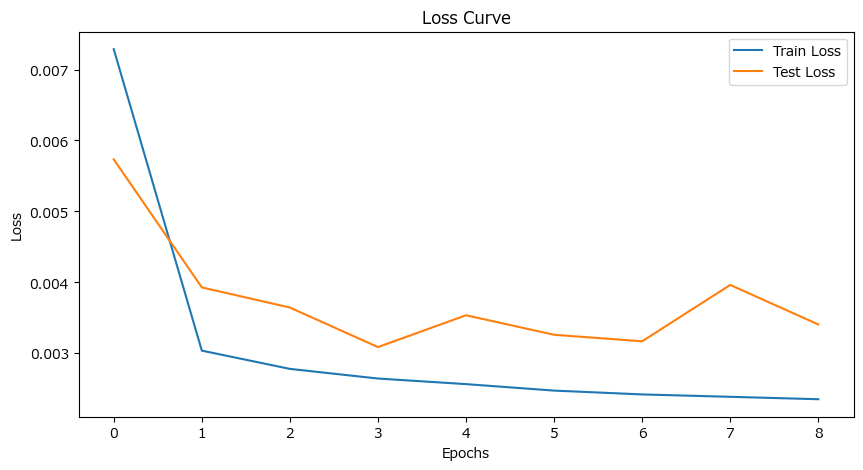

R2 Score: 0.8913817954793092
RMSE: 234.90187
CPU times: total: 28min 2s
Wall time: 7min 42s


In [25]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 1
    dropout = 0.0
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5
    
    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### num_layersを増やす（1→2層） + dropout0.5を追加 + hidden_sizeを増やす（128→256）

Epoch 1/20, Train Loss: 0.0073, Train RMSE: 346.0099, Test Loss: 0.0043, Test RMSE: 265.5125
Epoch 2/20, Train Loss: 0.0033, Train RMSE: 232.0899, Test Loss: 0.0038, Test RMSE: 248.1917
Epoch 3/20, Train Loss: 0.0030, Train RMSE: 222.0846, Test Loss: 0.0033, Test RMSE: 232.8223
Epoch 4/20, Train Loss: 0.0029, Train RMSE: 216.8484, Test Loss: 0.0039, Test RMSE: 251.7664
Epoch 5/20, Train Loss: 0.0028, Train RMSE: 213.0294, Test Loss: 0.0035, Test RMSE: 238.3809
Epoch 6/20, Train Loss: 0.0027, Train RMSE: 209.9142, Test Loss: 0.0029, Test RMSE: 217.1243
Epoch 7/20, Train Loss: 0.0026, Train RMSE: 208.4319, Test Loss: 0.0030, Test RMSE: 219.4232
Epoch 8/20, Train Loss: 0.0025, Train RMSE: 204.3038, Test Loss: 0.0030, Test RMSE: 220.4548
Epoch 9/20, Train Loss: 0.0025, Train RMSE: 202.8530, Test Loss: 0.0036, Test RMSE: 242.5276
Epoch 10/20, Train Loss: 0.0025, Train RMSE: 201.3667, Test Loss: 0.0044, Test RMSE: 268.4298
Epoch 11/20, Train Loss: 0.0025, Train RMSE: 200.7113, Test Loss: 0.0

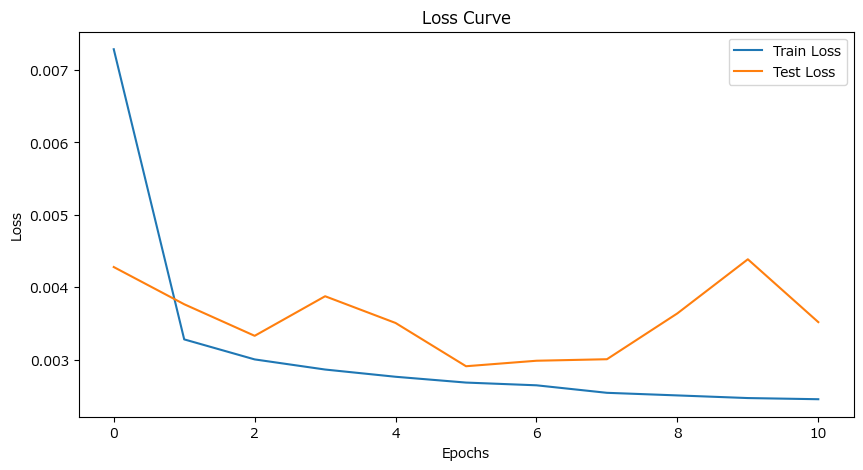

R2 Score: 0.8875177091251684
RMSE: 239.04367
CPU times: total: 1h 33min 56s
Wall time: 21min 44s


In [26]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 2 # 変更
    dropout = 0.5 # 変更
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5
    
    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 結果

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 2   | LSTM        | デフォルト設定                              |                   | 0.9059    | 218.6957  | 2分8秒          |                              |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 中間層            | 0.8863    | 240.29932 | 7分46秒           |                              |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 出力層            | 0.8904    | 235.97624 | 4分41秒          |                              |
| 8   | LSTM        | 隠れユニット数を128→256に変更              |                   | 0.8914    | 234.90187 | 7分33秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 中間層            | 0.8875    | 239.04367 | 20分52秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 出力層            | 0.9107    | 212.99484 | 12分9秒          | **LSTNの中で最良の性能**     |

- LSTMはRNNよりも明らかに高い性能を発揮していることが分かるが、単に層やユニット数を増やしてもデフォルトの設定を超えられない。
- ここでは、隠れユニット数を増やし、出力層にドロップアウトを適用したNo9が、過学習を防ぎつつ高精度を達成している
- さらに複雑さをあげて性能がどのように変化するかを確認する。

### num_layersを増やす（1→3層） + dropout0.5を追加

Epoch 1/20, Train Loss: 0.0081, Train RMSE: 363.9141, Test Loss: 0.0058, Test RMSE: 307.2963
Epoch 2/20, Train Loss: 0.0035, Train RMSE: 238.8499, Test Loss: 0.0035, Test RMSE: 235.7233
Epoch 3/20, Train Loss: 0.0032, Train RMSE: 228.3997, Test Loss: 0.0031, Test RMSE: 224.9070
Epoch 4/20, Train Loss: 0.0030, Train RMSE: 220.8423, Test Loss: 0.0034, Test RMSE: 234.5818
Epoch 5/20, Train Loss: 0.0029, Train RMSE: 217.3123, Test Loss: 0.0027, Test RMSE: 208.6928
Epoch 6/20, Train Loss: 0.0028, Train RMSE: 213.6541, Test Loss: 0.0028, Test RMSE: 215.5516
Epoch 7/20, Train Loss: 0.0027, Train RMSE: 210.3311, Test Loss: 0.0037, Test RMSE: 241.0089
Epoch 8/20, Train Loss: 0.0026, Train RMSE: 207.4081, Test Loss: 0.0034, Test RMSE: 234.6002
Epoch 9/20, Train Loss: 0.0026, Train RMSE: 206.6747, Test Loss: 0.0041, Test RMSE: 258.3312
Epoch 10/20, Train Loss: 0.0025, Train RMSE: 203.4534, Test Loss: 0.0031, Test RMSE: 225.7547
Early stopping triggered


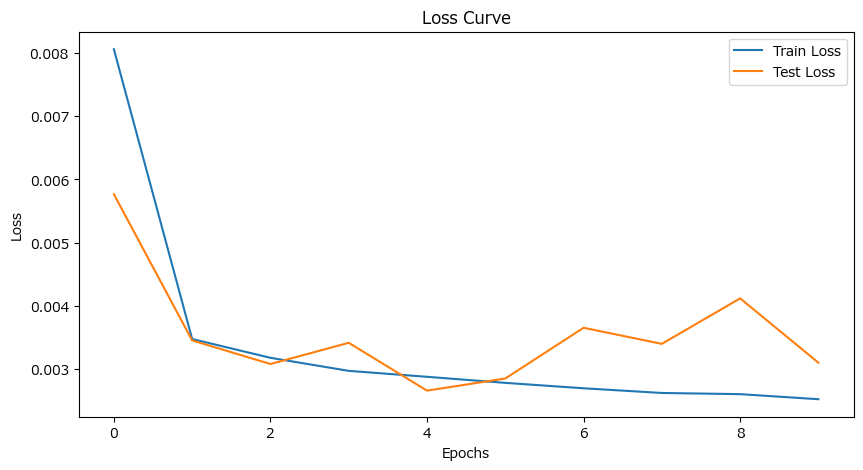

R2 Score: 0.8996763368548893
RMSE: 225.75473
CPU times: total: 44min 31s
Wall time: 13min 32s


In [27]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 3 # 変更
    dropout = 0.5 # 変更
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5
    
    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### num_layersを増やす（1→3層） + dropout0.5を追加 + hidden_sizeを増やす（128→256）

Epoch 1/20, Train Loss: 0.0068, Train RMSE: 333.6928, Test Loss: 0.0050, Test RMSE: 282.3243
Epoch 2/20, Train Loss: 0.0034, Train RMSE: 235.1139, Test Loss: 0.0036, Test RMSE: 240.1450
Epoch 3/20, Train Loss: 0.0031, Train RMSE: 225.8802, Test Loss: 0.0034, Test RMSE: 237.5988
Epoch 4/20, Train Loss: 0.0029, Train RMSE: 217.2000, Test Loss: 0.0033, Test RMSE: 230.6860
Epoch 5/20, Train Loss: 0.0028, Train RMSE: 214.3981, Test Loss: 0.0037, Test RMSE: 244.1317
Epoch 6/20, Train Loss: 0.0027, Train RMSE: 210.6397, Test Loss: 0.0027, Test RMSE: 208.8140
Epoch 7/20, Train Loss: 0.0027, Train RMSE: 209.0204, Test Loss: 0.0028, Test RMSE: 213.0592
Epoch 8/20, Train Loss: 0.0026, Train RMSE: 205.7059, Test Loss: 0.0033, Test RMSE: 229.5291
Epoch 9/20, Train Loss: 0.0025, Train RMSE: 203.9343, Test Loss: 0.0033, Test RMSE: 232.5893
Epoch 10/20, Train Loss: 0.0025, Train RMSE: 202.0433, Test Loss: 0.0034, Test RMSE: 234.1098
Epoch 11/20, Train Loss: 0.0024, Train RMSE: 200.2012, Test Loss: 0.0

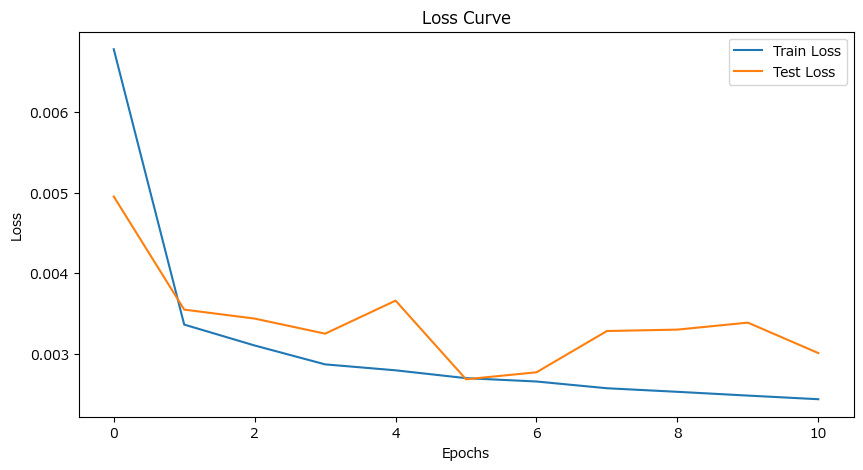

R2 Score: 0.9038598745635855
RMSE: 220.99757
CPU times: total: 2h 33min 5s
Wall time: 34min 24s


In [28]:
%%time

# メイン処理
def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 3 # 変更
    dropout = 0.5 # 変更
    learning_rate = 0.001
    num_epochs = 20
    batch_size = 128
    patience = 5
    
    model, criterion, optimizer = initialize_LSTMModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 2   | LSTM        | デフォルト設定                              |                   | 0.9059    | 218.6957  | 2分8秒          |                              |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 中間層            | 0.8863    | 240.29932 | 7分46秒           |                              |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 出力層            | 0.8904    | 235.97624 | 4分41秒          |                              |
| 8   | LSTM        | 隠れユニット数を128→256に変更              |                   | 0.8914    | 234.90187 | 7分33秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 中間層            | 0.8875    | 239.04367 | 20分52秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 出力層            | 0.9107    | 212.99484 | 12分9秒          | **LSTNの中で最良の性能**     |
| 10  | LSTM        | LSTM層3層                                    | 中間層            | 0.8997    | 225.75473 | 7分33秒           |                              |
| 10  | LSTM        | LSTM層3層  　                               | 出力層            | 0.8957    | 230.16785 | 4分56秒          |                              |
| 11  | LSTM        | LSTM層3層、隠れユニット数256に変更          | 中間層            | 0.9039    | 220.99757 | 33分40秒         |                              |
| 11  | LSTM        | LSTM層3層、隠れユニット数256に変更          | 出力層            | 0.8855    | 241.15762 | 14分24秒         |                              |

- LSTM層を3層にして複雑さをあげてみたが、性能は向上しなかった。
- また、明らかにdropoutを中間層に適用した場合のほうが計算コストが上がり処理時間がかかっていることが分かる。

## 6.0 GRU パラメータ調整

- この章では、GRUのパラメータ調整を行う。
- モデルの特徴として、RNNよりも表現力が高く、LSTMよりも軽量なことが挙げられ、長期依存関係をある程度は学習可能である。
- このモデルでのパラメータ調整内容としてはLSTMとの比較を目的に同様のパラメータを調整していきたい。
1. `num_layers`を増やす（1→2層）
2. `hidden_size`を増やす（128→256）
3. 上記の両方の施策を試す

### num_layersを増やす（1→2層） + dropout0.5を追加

Epoch 1/20, Train Loss: 0.0078, Train RMSE: 358.7517, Test Loss: 0.0048, Test RMSE: 278.8577
Epoch 2/20, Train Loss: 0.0035, Train RMSE: 241.3929, Test Loss: 0.0039, Test RMSE: 252.1807
Epoch 3/20, Train Loss: 0.0030, Train RMSE: 222.3467, Test Loss: 0.0045, Test RMSE: 271.4142
Epoch 4/20, Train Loss: 0.0028, Train RMSE: 216.1551, Test Loss: 0.0028, Test RMSE: 212.7932
Epoch 5/20, Train Loss: 0.0027, Train RMSE: 211.0873, Test Loss: 0.0035, Test RMSE: 239.6142
Epoch 6/20, Train Loss: 0.0027, Train RMSE: 209.3957, Test Loss: 0.0045, Test RMSE: 270.8161
Epoch 7/20, Train Loss: 0.0026, Train RMSE: 206.4581, Test Loss: 0.0039, Test RMSE: 251.0333
Epoch 8/20, Train Loss: 0.0026, Train RMSE: 205.4482, Test Loss: 0.0042, Test RMSE: 262.6567
Epoch 9/20, Train Loss: 0.0025, Train RMSE: 203.9014, Test Loss: 0.0030, Test RMSE: 220.3754
Early stopping triggered


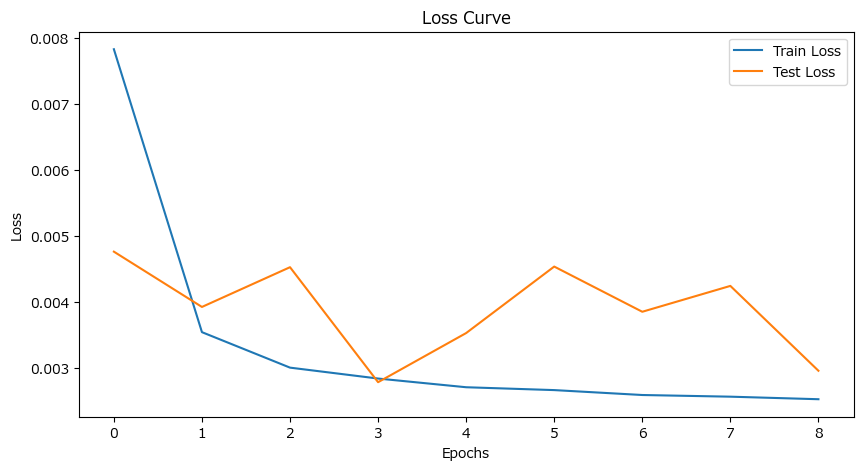

R2 Score: 0.9044003955012243
RMSE: 220.37544
CPU times: total: 17min 42s
Wall time: 13min 58s


In [29]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 2 # 変更
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.5 # 変更
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### hidden_sizeを増やす（128→256）

Epoch 1/20, Train Loss: 0.0069, Train RMSE: 335.6928, Test Loss: 0.0038, Test RMSE: 250.8825
Epoch 2/20, Train Loss: 0.0031, Train RMSE: 225.7559, Test Loss: 0.0033, Test RMSE: 229.7936
Epoch 3/20, Train Loss: 0.0028, Train RMSE: 212.6261, Test Loss: 0.0030, Test RMSE: 220.4145
Epoch 4/20, Train Loss: 0.0026, Train RMSE: 205.5991, Test Loss: 0.0029, Test RMSE: 216.0145
Epoch 5/20, Train Loss: 0.0025, Train RMSE: 202.1082, Test Loss: 0.0027, Test RMSE: 210.4839
Epoch 6/20, Train Loss: 0.0024, Train RMSE: 199.4249, Test Loss: 0.0032, Test RMSE: 226.3453
Epoch 7/20, Train Loss: 0.0024, Train RMSE: 198.3060, Test Loss: 0.0028, Test RMSE: 212.3132
Epoch 8/20, Train Loss: 0.0023, Train RMSE: 196.3252, Test Loss: 0.0026, Test RMSE: 205.2151
Epoch 9/20, Train Loss: 0.0023, Train RMSE: 194.5242, Test Loss: 0.0028, Test RMSE: 210.1013
Epoch 10/20, Train Loss: 0.0023, Train RMSE: 192.3642, Test Loss: 0.0030, Test RMSE: 220.2932
Epoch 11/20, Train Loss: 0.0022, Train RMSE: 192.1142, Test Loss: 0.0

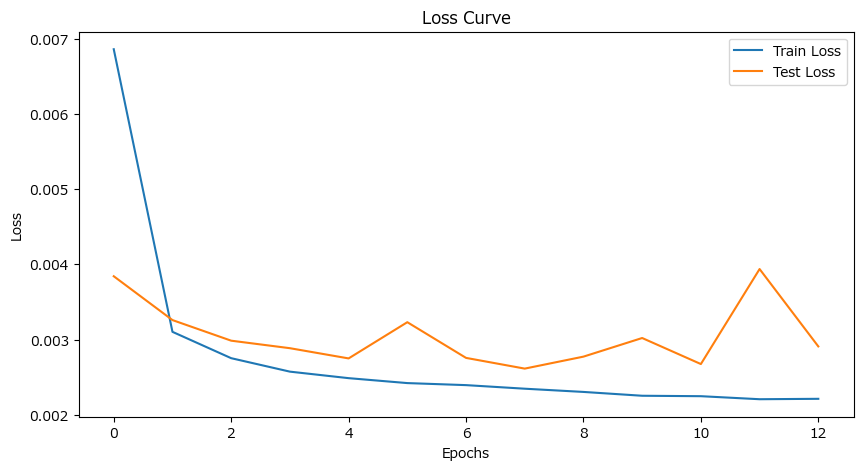

R2 Score: 0.9069852741930156
RMSE: 217.37572
CPU times: total: 23min 3s
Wall time: 20min 41s


In [30]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### num_layersを増やす（1→2層） + dropout0.5を追加 + hidden_sizeを増やす（128→256）

Epoch 1/20, Train Loss: 0.0067, Train RMSE: 331.8301, Test Loss: 0.0046, Test RMSE: 274.8862
Epoch 2/20, Train Loss: 0.0032, Train RMSE: 230.3756, Test Loss: 0.0054, Test RMSE: 296.0377
Epoch 3/20, Train Loss: 0.0029, Train RMSE: 218.1521, Test Loss: 0.0039, Test RMSE: 248.9563
Epoch 4/20, Train Loss: 0.0027, Train RMSE: 212.4908, Test Loss: 0.0027, Test RMSE: 210.6990
Epoch 5/20, Train Loss: 0.0026, Train RMSE: 208.1137, Test Loss: 0.0037, Test RMSE: 245.1621
Epoch 6/20, Train Loss: 0.0026, Train RMSE: 205.7785, Test Loss: 0.0029, Test RMSE: 215.7224
Epoch 7/20, Train Loss: 0.0025, Train RMSE: 201.0764, Test Loss: 0.0028, Test RMSE: 215.8266
Epoch 8/20, Train Loss: 0.0025, Train RMSE: 200.6191, Test Loss: 0.0050, Test RMSE: 284.5740
Epoch 9/20, Train Loss: 0.0024, Train RMSE: 197.9243, Test Loss: 0.0027, Test RMSE: 212.2951
Early stopping triggered


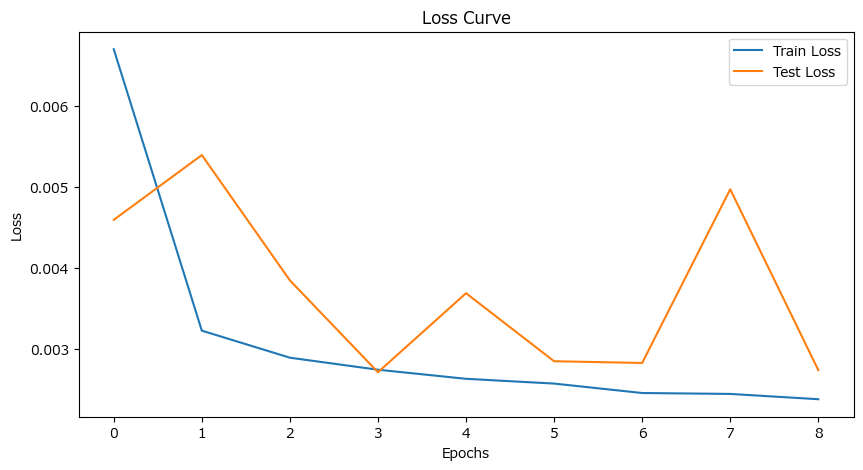

R2 Score: 0.9112824246354729
RMSE: 212.29512
CPU times: total: 52min 23s
Wall time: 23min 34s


In [31]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 2 # 変更
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.001
    dropout = 0.5 # 変更
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 結果1

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 2  | GRU         | デフォルト設定                              | 0.9085    | 215.6023  | 3分47秒         |　　         |                              |
| 12  | GRU         | GRU層2層 　                                   | 中間層            | 0.8684    | 258.5563 | 7分39秒          |                              |
| 12  | GRU         | GRU層2層                                    | 出力層            | 0.9044    | 220.37544  | 5分48秒        |                              |
| 13  | GRU         | 隠れユニット数を128→256に変更               |                   | 0.9070    | 217.37572 | 7分30秒          |                              |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更 　          | 中間層            | 0.8972    | 228.48074 | 12分48秒         |  |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更           | 出力層            | 0.9113    | 212.29512 | 10分36秒         | **GRUの中で最良の性能**               |

- GRUは複雑さをあげることによる性能の大きな向上は見られなかったが、LSTMと同じく2層にして隠れユニットを増やす方針が良いことが分かった。また、LSTMと比べても全体的に性能が良く処理時間も短い。
- そこで、GRUのLSTMよりも計算効率が高いという特徴を活かすために、学習率とバッチサイズの大きさを変えてみたい。
    - LSTMは「忘却ゲート」「入力ゲート」「出力ゲート」の3つのゲートを持つが、GRUは「更新ゲート」「リセットゲート」の2つだけ → これにより学習時の計算量が少なく、バッチサイズを大きくしても処理負荷が増えにくい。また、学習率が適切であれば勾配が安定して損失の減少がスムーズに進む。
    - 学習率：モデルの重みを更新する際のステップサイズを決定するパラメータ。
        - 高い場合は、収束が不安定となり、損失が振動するか、発散する可能性がある。
        - 低い場合は、収束に時間がかかり、十分な学習が進まない。
    - バッチサイズ：モデルが1回の更新で処理するサンプルの数を決定するパラメータ
        - 大きい場合は、更新回数が減るため計算効率が向上するがメモリの制約を超える可能性がある。
        - 小さい場合は、メモリ負担が軽くなるが1エポックあたりの更新回数が多くなり、計算コストが増加する。

### 学習率0.002

Epoch 1/20, Train Loss: 0.0072, Train RMSE: 344.9163, Test Loss: 0.0039, Test RMSE: 252.5079
Epoch 2/20, Train Loss: 0.0030, Train RMSE: 221.9760, Test Loss: 0.0040, Test RMSE: 253.7079
Epoch 3/20, Train Loss: 0.0026, Train RMSE: 208.1112, Test Loss: 0.0051, Test RMSE: 287.0398
Epoch 4/20, Train Loss: 0.0025, Train RMSE: 203.8547, Test Loss: 0.0034, Test RMSE: 234.7675
Epoch 5/20, Train Loss: 0.0024, Train RMSE: 199.3976, Test Loss: 0.0037, Test RMSE: 247.2234
Epoch 6/20, Train Loss: 0.0024, Train RMSE: 197.7770, Test Loss: 0.0026, Test RMSE: 206.4764
Epoch 7/20, Train Loss: 0.0023, Train RMSE: 196.1653, Test Loss: 0.0033, Test RMSE: 230.5443
Epoch 8/20, Train Loss: 0.0023, Train RMSE: 194.8965, Test Loss: 0.0030, Test RMSE: 220.6063
Epoch 9/20, Train Loss: 0.0022, Train RMSE: 191.9740, Test Loss: 0.0029, Test RMSE: 219.9018
Epoch 10/20, Train Loss: 0.0022, Train RMSE: 191.2318, Test Loss: 0.0031, Test RMSE: 223.4046
Epoch 11/20, Train Loss: 0.0022, Train RMSE: 190.0651, Test Loss: 0.0

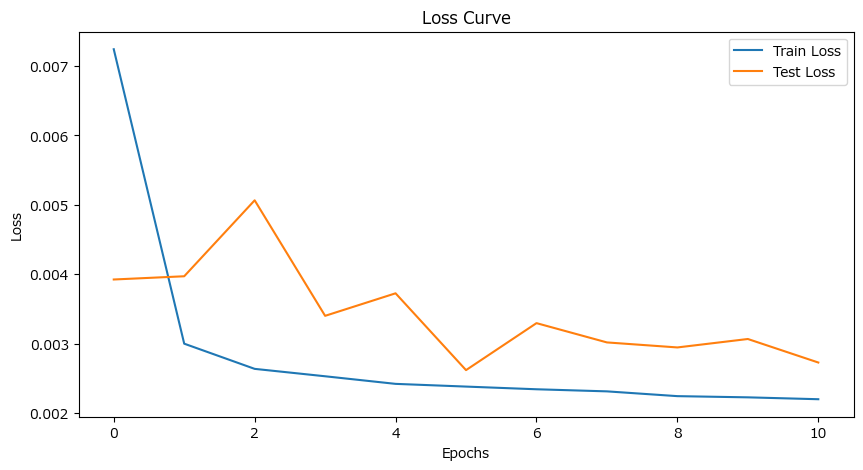

R2 Score: 0.9130258375863426
RMSE: 210.19882
CPU times: total: 8min 3s
Wall time: 8min 3s


In [32]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.002 # 変更
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 学習率0.003

Epoch 1/20, Train Loss: 0.0066, Train RMSE: 328.7488, Test Loss: 0.0040, Test RMSE: 254.4971
Epoch 2/20, Train Loss: 0.0028, Train RMSE: 214.5860, Test Loss: 0.0043, Test RMSE: 265.1933
Epoch 3/20, Train Loss: 0.0026, Train RMSE: 205.7724, Test Loss: 0.0051, Test RMSE: 288.5805
Epoch 4/20, Train Loss: 0.0025, Train RMSE: 201.8223, Test Loss: 0.0037, Test RMSE: 245.9132
Epoch 5/20, Train Loss: 0.0024, Train RMSE: 197.7558, Test Loss: 0.0040, Test RMSE: 256.2819
Epoch 6/20, Train Loss: 0.0023, Train RMSE: 196.3092, Test Loss: 0.0027, Test RMSE: 207.8409
Epoch 7/20, Train Loss: 0.0023, Train RMSE: 195.0884, Test Loss: 0.0028, Test RMSE: 214.3677
Epoch 8/20, Train Loss: 0.0023, Train RMSE: 194.3707, Test Loss: 0.0030, Test RMSE: 221.1162
Epoch 9/20, Train Loss: 0.0022, Train RMSE: 190.7457, Test Loss: 0.0033, Test RMSE: 232.8210
Epoch 10/20, Train Loss: 0.0022, Train RMSE: 190.6804, Test Loss: 0.0031, Test RMSE: 222.9597
Epoch 11/20, Train Loss: 0.0022, Train RMSE: 189.0379, Test Loss: 0.0

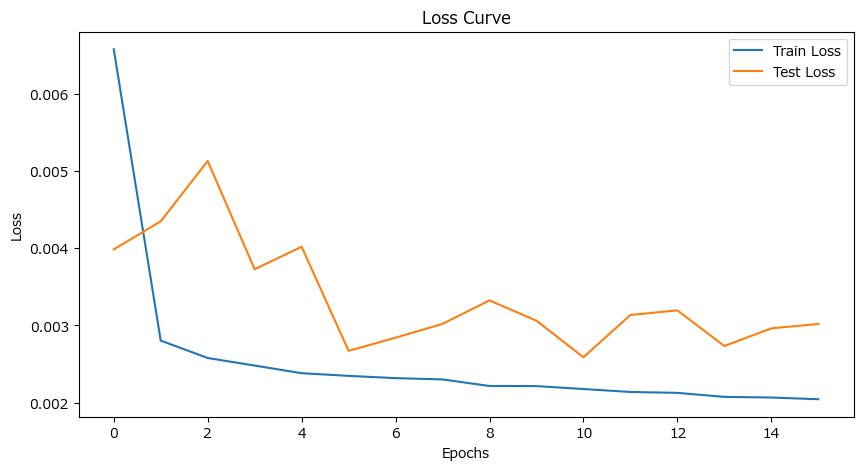

R2 Score: 0.9025130449769865
RMSE: 222.54018
CPU times: total: 11min 37s
Wall time: 11min 34s


In [33]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.003 # 変更
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### hidden_sizeを増やす（128→256） + 学習率0.002

Epoch 1/20, Train Loss: 0.0059, Train RMSE: 310.8304, Test Loss: 0.0054, Test RMSE: 298.9241
Epoch 2/20, Train Loss: 0.0029, Train RMSE: 218.4251, Test Loss: 0.0029, Test RMSE: 216.8172
Epoch 3/20, Train Loss: 0.0026, Train RMSE: 207.9843, Test Loss: 0.0042, Test RMSE: 260.9916
Epoch 4/20, Train Loss: 0.0025, Train RMSE: 201.4145, Test Loss: 0.0030, Test RMSE: 222.7222
Epoch 5/20, Train Loss: 0.0024, Train RMSE: 199.7149, Test Loss: 0.0032, Test RMSE: 226.5159
Epoch 6/20, Train Loss: 0.0024, Train RMSE: 196.7396, Test Loss: 0.0028, Test RMSE: 210.9935
Epoch 7/20, Train Loss: 0.0023, Train RMSE: 195.3068, Test Loss: 0.0027, Test RMSE: 208.2092
Epoch 8/20, Train Loss: 0.0023, Train RMSE: 193.0554, Test Loss: 0.0025, Test RMSE: 200.2529
Epoch 9/20, Train Loss: 0.0022, Train RMSE: 190.6262, Test Loss: 0.0026, Test RMSE: 204.2793
Epoch 10/20, Train Loss: 0.0021, Train RMSE: 187.7072, Test Loss: 0.0027, Test RMSE: 208.0394
Epoch 11/20, Train Loss: 0.0022, Train RMSE: 188.0324, Test Loss: 0.0

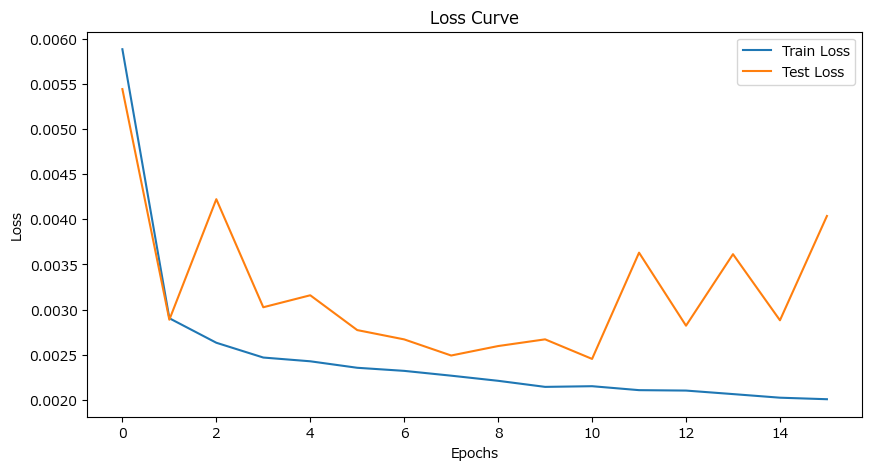

R2 Score: 0.8706653444409872
RMSE: 256.326
CPU times: total: 28min 36s
Wall time: 25min 31s


In [34]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 256 # 変更
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.002 # 変更
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### batch_sizeを増やす（128→258）

Epoch 1/20, Train Loss: 0.0116, Train RMSE: 435.6249, Test Loss: 0.0072, Test RMSE: 341.0631
Epoch 2/20, Train Loss: 0.0049, Train RMSE: 283.9463, Test Loss: 0.0069, Test RMSE: 331.6633
Epoch 3/20, Train Loss: 0.0037, Train RMSE: 245.7113, Test Loss: 0.0052, Test RMSE: 289.0449
Epoch 4/20, Train Loss: 0.0030, Train RMSE: 222.4637, Test Loss: 0.0034, Test RMSE: 234.7479
Epoch 5/20, Train Loss: 0.0027, Train RMSE: 211.9012, Test Loss: 0.0038, Test RMSE: 248.3195
Epoch 6/20, Train Loss: 0.0026, Train RMSE: 207.1104, Test Loss: 0.0037, Test RMSE: 244.3663
Epoch 7/20, Train Loss: 0.0025, Train RMSE: 204.1172, Test Loss: 0.0039, Test RMSE: 249.7316
Epoch 8/20, Train Loss: 0.0025, Train RMSE: 202.3735, Test Loss: 0.0029, Test RMSE: 214.9615
Epoch 9/20, Train Loss: 0.0024, Train RMSE: 200.4881, Test Loss: 0.0033, Test RMSE: 231.0904
Epoch 10/20, Train Loss: 0.0024, Train RMSE: 199.4019, Test Loss: 0.0047, Test RMSE: 273.1283
Epoch 11/20, Train Loss: 0.0024, Train RMSE: 197.8646, Test Loss: 0.0

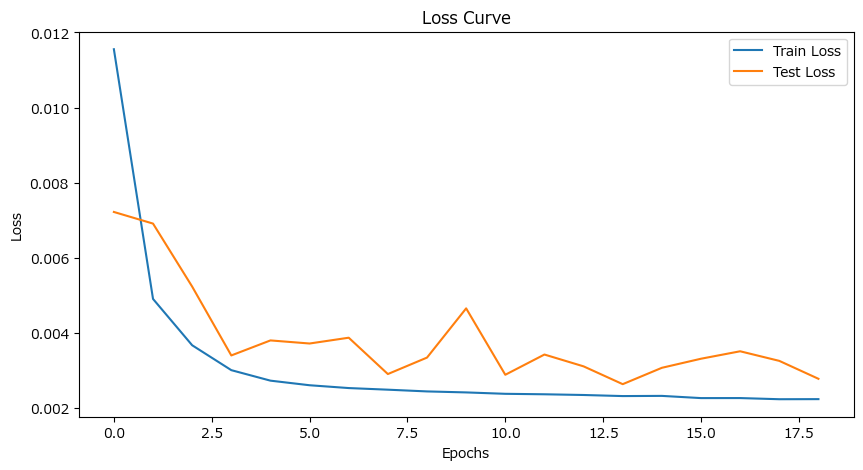

R2 Score: 0.9129750962736322
RMSE: 210.26015
CPU times: total: 12min 54s
Wall time: 12min 17s


In [35]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 256 # 変更
    learning_rate = 0.001
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### batch_sizeを増やす（128→258） + 学習率0.002

Epoch 1/20, Train Loss: 0.0099, Train RMSE: 404.1858, Test Loss: 0.0063, Test RMSE: 317.2951
Epoch 2/20, Train Loss: 0.0039, Train RMSE: 253.2661, Test Loss: 0.0054, Test RMSE: 291.7050
Epoch 3/20, Train Loss: 0.0029, Train RMSE: 217.5959, Test Loss: 0.0038, Test RMSE: 245.3068
Epoch 4/20, Train Loss: 0.0026, Train RMSE: 208.4022, Test Loss: 0.0034, Test RMSE: 232.1234
Epoch 5/20, Train Loss: 0.0025, Train RMSE: 203.6423, Test Loss: 0.0035, Test RMSE: 237.1663
Epoch 6/20, Train Loss: 0.0024, Train RMSE: 200.1362, Test Loss: 0.0040, Test RMSE: 254.6360
Epoch 7/20, Train Loss: 0.0024, Train RMSE: 198.5244, Test Loss: 0.0040, Test RMSE: 250.8742
Epoch 8/20, Train Loss: 0.0024, Train RMSE: 197.2611, Test Loss: 0.0029, Test RMSE: 216.9397
Epoch 9/20, Train Loss: 0.0023, Train RMSE: 194.7465, Test Loss: 0.0034, Test RMSE: 234.9355
Epoch 10/20, Train Loss: 0.0023, Train RMSE: 193.7758, Test Loss: 0.0042, Test RMSE: 258.1640
Epoch 11/20, Train Loss: 0.0023, Train RMSE: 192.3047, Test Loss: 0.0

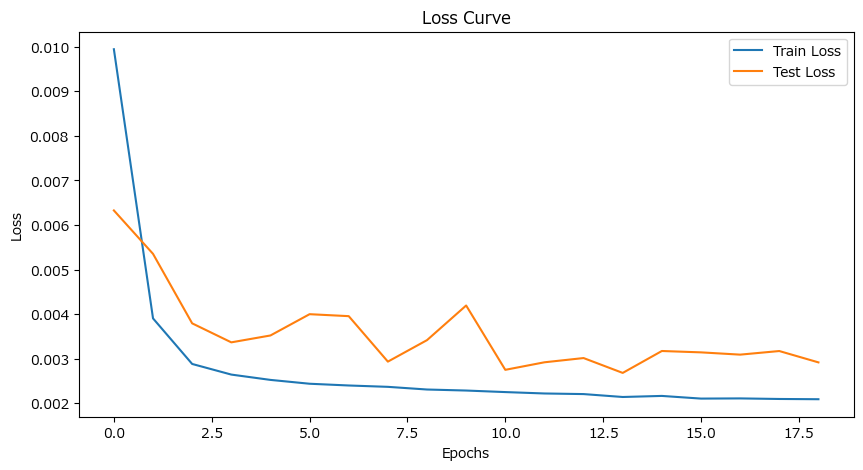

R2 Score: 0.9087464229614726
RMSE: 215.30798
CPU times: total: 12min 52s
Wall time: 12min 18s


In [36]:
%%time

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 256 # 変更
    learning_rate = 0.002 # 変更
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)

if __name__ == "__main__":
    main()

### 結果2

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 3   | GRU         | デフォルト設定                              |                   | 0.9085    | 215.6023  | 3分47秒         |                              |
| 12  | GRU         | GRU層2層 　                                   | 中間層            | 0.8684    | 258.5563 | 7分39秒          |                              |
| 12  | GRU         | GRU層2層                                    | 出力層            | 0.9044    | 220.37544  | 5分48秒        |                              |
| 13  | GRU         | 隠れユニット数を128→256に変更               |                   | 0.9070    | 217.37572 | 7分30秒          |                              |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更 　          | 中間層            | 0.8972    | 228.48074 | 12分48秒         |  |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更           | 出力層            | 0.9113    | 212.29512 | 10分36秒         |                              |
| 15  | GRU         | 学習率0.002　　                                |                   | 0.9130    | 210.19882 | 4分13秒          | **GRUおよび全体の中で最良の性能**     |
| 16  | GRU         | 学習率0.003　　                              |                   | 0.9025    | 222.54018 | 4分16秒              |                              |
| 17  | GRU         | 学習率0.002、隠れユニット数256に変更              |                   | 0.8707    | 256.326   | 9分11秒          |                              |
| 18  | GRU         | バッチサイズを128→256に変更                 |                   | 0.9130    | 210.26015 | 4分56秒          |                              |
| 19  | GRU         | 学習率0.002、バッチサイズを128→256に変更    |                   | 0.9087    | 215.30798 | 3分25秒          |                              |

- 学習率を0.002にしたときと、バッチサイズを256に大きくしたときに性能が向上した。
- 特に、学習率を0.002としたときに性能が向上したため、学習率が損失の減少が安定的に行われることに寄与したと推測する（実行時間の短縮は見られなかった）。

## 7.0 まとめ

- 今回の試行結果は下表のとおりである。

| No  | モデル       | 変更点                                      | ドロップアウト適用 | R2 Score  | RMSE      | 実行時間          | 結果                          |
|-----|-------------|---------------------------------------------|-------------------|-----------|-----------|-------------------|------------------------------|
| 1   | RNN   | デフォルト設定                              |                   | 0.8888    | 237.65305 | 3分5秒           |                              |
| 2   | LSTM        | デフォルト設定                              |                   | 0.9059    | 218.6957  | 2分8秒          |                              |
| 3   | GRU         | デフォルト設定                              |                   | 0.9085    | 215.6023  | 3分47秒         |                              |
| 4   | RNN   | RNN層を2層に変更（1→2層）                   | 中間層            | 0.8926    | 233.60146 | 9分24秒          |                              |
| 4   | RNN   | RNN層を2層に変更（1→2層）                   | 出力層            | 0.8835    | 243.29239 | 3分5秒            |                              |
| 5   | RNN   | 隠れユニット数を128→64に変更                |                   | 0.8717    | 255.28548 | 3分23秒           |                              |
| 6   | RNN   | RNN層2層、隠れユニット数64に変更            | 中間層            | 0.8594    | 267.24866 | 2分33秒          |                              |
| 6   | RNN   | RNN層2層、隠れユニット数64に変更            | 出力層            | 0.8960    | 229.85461 | 3分7秒          | **RNNの中で最良の性能**     |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 中間層            | 0.8863    | 240.29932 | 7分46秒           |                              |
| 7   | LSTM        | LSTM層を2層に変更（1→2層）                  | 出力層            | 0.8904    | 235.97624 | 4分41秒          |                              |
| 8   | LSTM        | 隠れユニット数を128→256に変更              |                   | 0.8914    | 234.90187 | 7分33秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 中間層            | 0.8875    | 239.04367 | 20分52秒          |                              |
| 9   | LSTM        | LSTM層2層、隠れユニット数256に変更          | 出力層            | 0.9107    | 212.99484 | 12分6秒          | **LSTNの中で最良の性能**     |
| 10  | LSTM        | LSTM層3層                                    | 中間層            | 0.8997    | 225.75473 | 7分33秒           |                              |
| 10  | LSTM        | LSTM層3層  　                               | 出力層            | 0.8957    | 230.16785 | 4分56秒          |                              |
| 11  | LSTM        | LSTM層3層、隠れユニット数256に変更          | 中間層            | 0.9039    | 220.99757 | 33分40秒         |                              |
| 11  | LSTM        | LSTM層3層、隠れユニット数256に変更          | 出力層            | 0.8855    | 241.15762 | 14分24秒         |                              |
| 12  | GRU         | GRU層2層 　                                   | 中間層            | 0.8684    | 258.5563 | 7分39秒          |                              |
| 12  | GRU         | GRU層2層                                    | 出力層            | 0.9044    | 220.37544  | 5分48秒        |                              |
| 13  | GRU         | 隠れユニット数を128→256に変更               |                   | 0.9070    | 217.37572 | 7分30秒          |                              |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更 　          | 中間層            | 0.8972    | 228.48074 | 12分48秒         |  |
| 14  | GRU         | GRU層2層、隠れユニット数256に変更           | 出力層            | 0.9113    | 212.29512 | 10分36秒         |                              |
| 15  | GRU         | 学習率0.002　　                                |                   | 0.9130    | 210.19882 | 4分13秒          | **GRUおよび全体の中で最良の性能**     |
| 16  | GRU         | 学習率0.003　　                              |                   | 0.9025    | 222.54018 | 4分16秒              |                              |
| 17  | GRU         | 隠れユニット数256、学習率0.002              |                   | 0.8707    | 256.326   | 9分11秒          |                              |
| 18  | GRU         | バッチサイズを128→256に変更                 |                   | 0.9130    | 210.26015 | 4分56秒          |                              |
| 19  | GRU         | 学習率0.002、バッチサイズを128→256に変更    |                   | 0.9087    | 215.30798 | 3分25秒          |                              |

- 今回一番良い性能だったのはデフォルトの設定から、学習率を0.002に変えたGRUモデルであった。
- GRUはRNNやLSTMと比べても精度が優れていることが分かる。最後に最良のモデルであるNo.15の予測値と残差を可視化したい。

### 7.1 結果の可視化

#### 予測値と実測値の折れ線グラフ

In [37]:
# モデル定義
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.dropout = nn.Dropout(dropout) 出力層にdropoutを適用する場合
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

# モデル初期化
def initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout=0.0):
    input_size = X_train_scaled.shape[1]
    model = GRUModel(input_size, hidden_size, 1, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

def main():
    set_seed(42)

    # ハイパーパラメータ設定
    hidden_size = 128
    num_layers = 1
    num_epochs = 20
    batch_size = 128
    learning_rate = 0.002 # 変更
    dropout = 0.0
    patience = 5
    
    model, criterion, optimizer = initialize_GRUModel(X_train_scaled, hidden_size, num_layers, learning_rate, dropout)
    train_loader = DataLoader(TensorDataset(train_sequences, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_sequences, test_labels), batch_size=batch_size, shuffle=False)
    train_losses, train_rmse, test_losses, test_rmse, test_predictions, test_targets, train_predictions, train_targets = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scaler_y, num_epochs, patience
    )
    plot_and_evaluate(train_losses, test_losses, train_rmse, test_rmse, test_targets, test_predictions)
    return test_predictions, test_targets, train_predictions, train_targets

def plot_time_series(train_targets, train_predictions, test_targets, test_predictions):
    plt.figure(figsize=(30, 10))
    plt.plot(train_targets, label="Train Targets", alpha=0.7)
    plt.plot(train_predictions, label="Train Predictions", alpha=0.7)
    plt.plot(range(len(train_targets), len(train_targets) + len(test_targets)), test_targets, label="Test Targets", alpha=0.7)
    plt.plot(range(len(train_targets), len(train_targets) + len(test_predictions)), test_predictions, label="Test Predictions", alpha=0.7)
    plt.legend()
    plt.title("Time Series Predictions vs Targets")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

Epoch 1/20, Train Loss: 0.0072, Train RMSE: 344.9163, Test Loss: 0.0039, Test RMSE: 252.5079
Epoch 2/20, Train Loss: 0.0030, Train RMSE: 221.9760, Test Loss: 0.0040, Test RMSE: 253.7079
Epoch 3/20, Train Loss: 0.0026, Train RMSE: 208.1112, Test Loss: 0.0051, Test RMSE: 287.0398
Epoch 4/20, Train Loss: 0.0025, Train RMSE: 203.8547, Test Loss: 0.0034, Test RMSE: 234.7675
Epoch 5/20, Train Loss: 0.0024, Train RMSE: 199.3976, Test Loss: 0.0037, Test RMSE: 247.2234
Epoch 6/20, Train Loss: 0.0024, Train RMSE: 197.7770, Test Loss: 0.0026, Test RMSE: 206.4764
Epoch 7/20, Train Loss: 0.0023, Train RMSE: 196.1653, Test Loss: 0.0033, Test RMSE: 230.5443
Epoch 8/20, Train Loss: 0.0023, Train RMSE: 194.8965, Test Loss: 0.0030, Test RMSE: 220.6063
Epoch 9/20, Train Loss: 0.0022, Train RMSE: 191.9740, Test Loss: 0.0029, Test RMSE: 219.9018
Epoch 10/20, Train Loss: 0.0022, Train RMSE: 191.2318, Test Loss: 0.0031, Test RMSE: 223.4046
Epoch 11/20, Train Loss: 0.0022, Train RMSE: 190.0651, Test Loss: 0.0

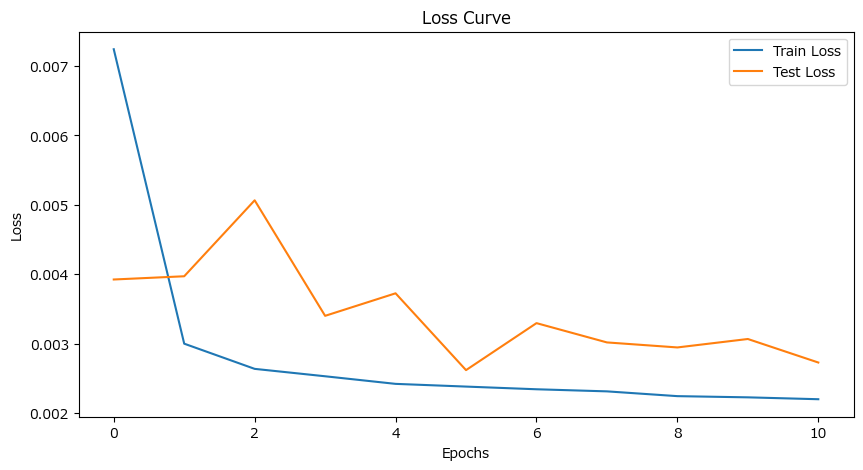

R2 Score: 0.9130258375863426
RMSE: 210.19882
Test Predictions: [[2845.3438]
 [2742.2405]
 [2722.543 ]
 ...
 [3205.6077]
 [3028.1355]
 [2799.2224]]
Test Targets: [[2560.]
 [2461.]
 [2430.]
 ...
 [2928.]
 [2761.]
 [2611.]]


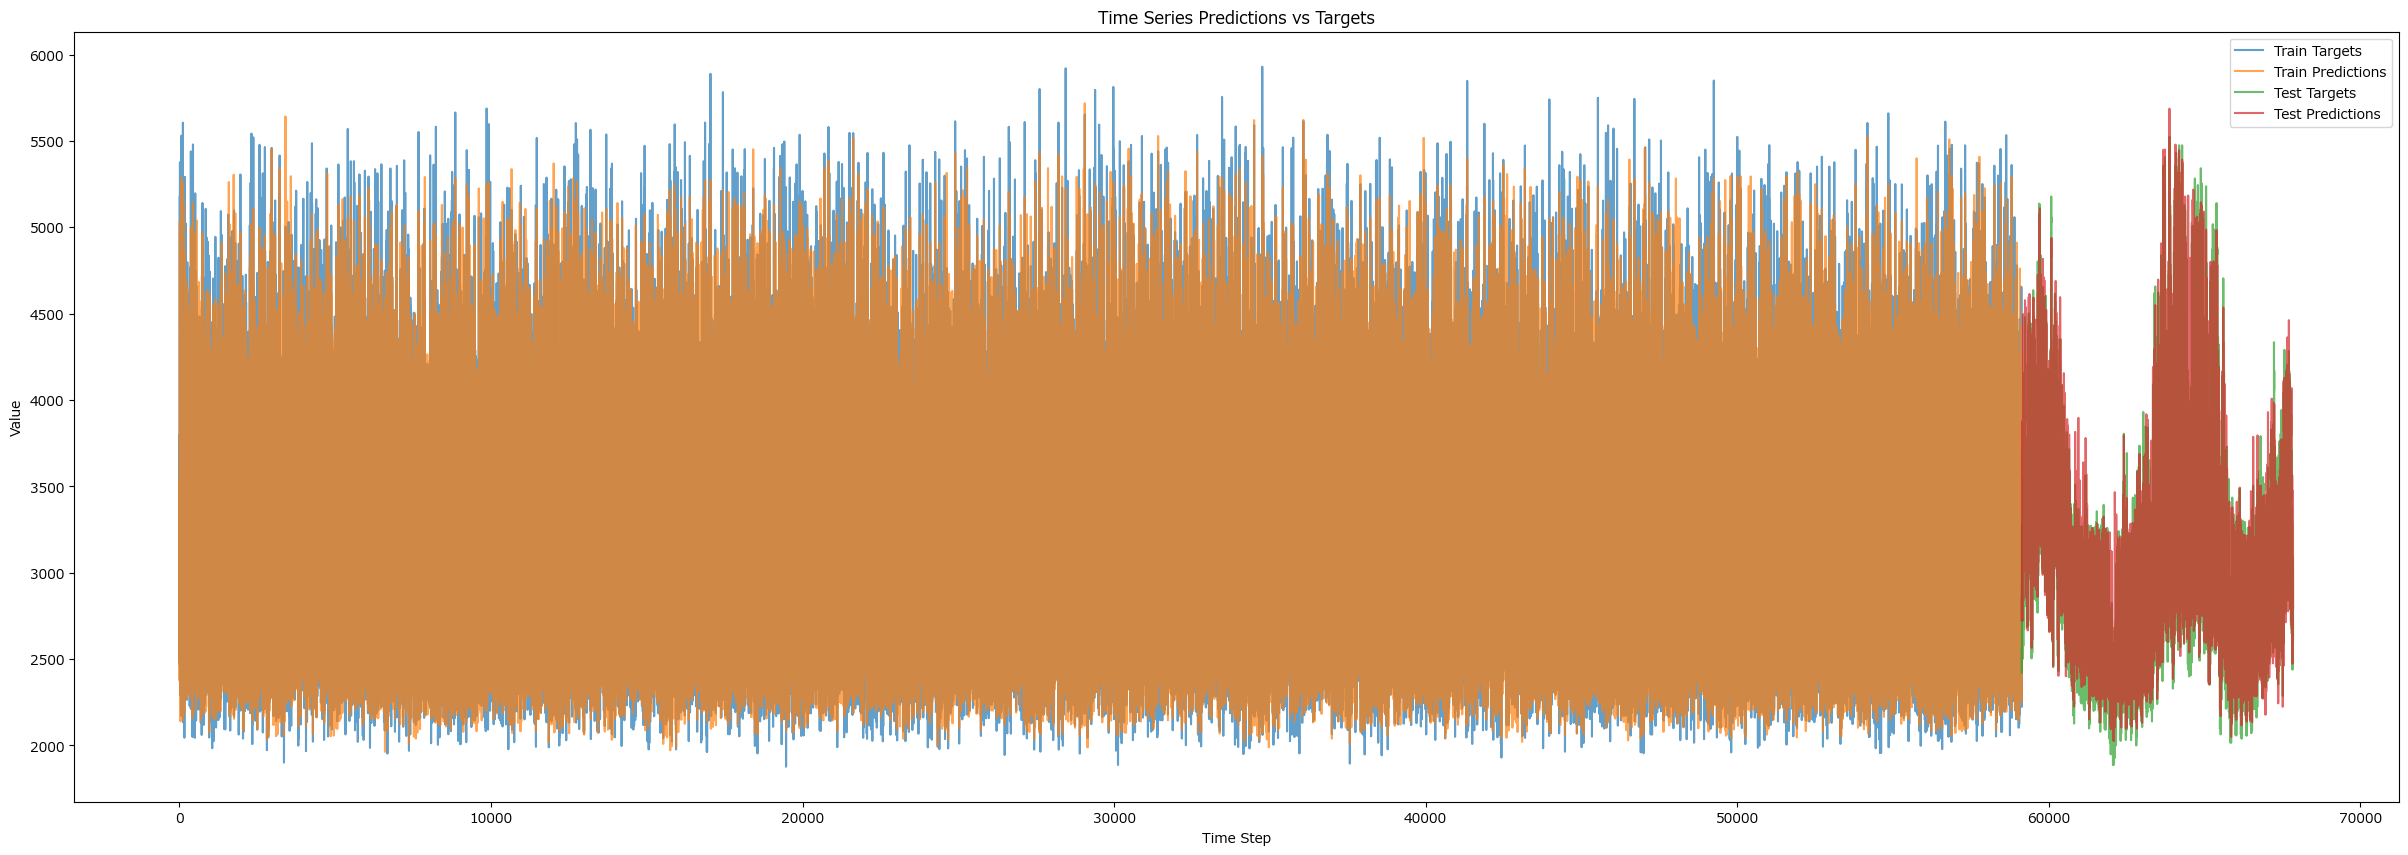

In [38]:
if __name__ == "__main__":
    # main関数の戻り値として値を受け取る
    test_predictions, test_targets, train_predictions, train_targets = main()

    # 予測値と実測値を表示する
    print("Test Predictions:", test_predictions)
    print("Test Targets:", test_targets)

    # 時系列プロットを作成する
    plot_time_series(train_targets, train_predictions, test_targets, test_predictions)

- 全期間をプロットすると見づらいので予測する2023年のみを抜き出してみる

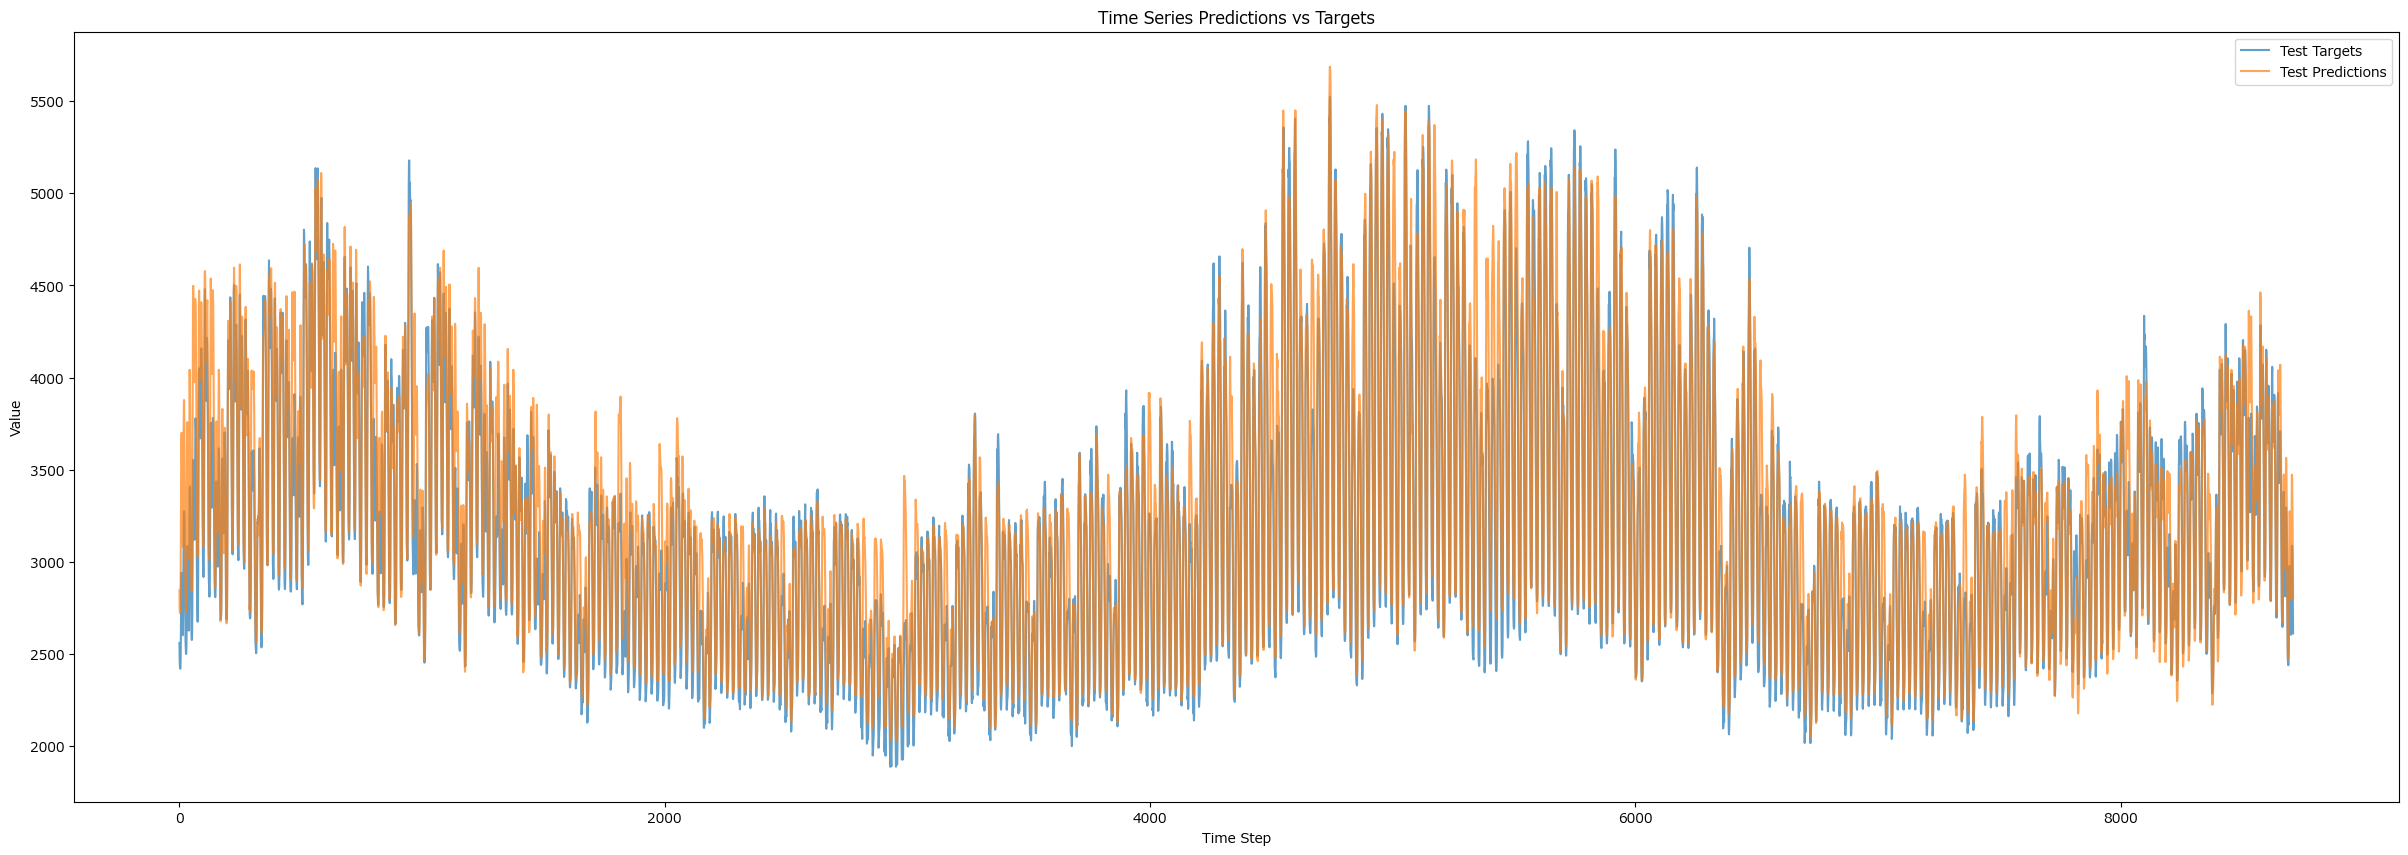

In [39]:
def plot_time_series(train_targets, train_predictions, test_targets, test_predictions):
    plt.figure(figsize=(30, 10))
    plt.plot(test_targets, label="Test Targets", alpha=0.7)
    plt.plot(test_predictions, label="Test Predictions", alpha=0.7)
    plt.legend()
    plt.title("Time Series Predictions vs Targets")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

plot_time_series(train_targets, train_predictions, test_targets, test_predictions)

- おおむね上昇や下降の傾向をつかめていることが分かる。
- グラフの下側に青色の実測値が見えているため、説明変数の傾向のわりに実際の電力消費量がそこまで大きくならなかった日の予測が外れているように推測する。
- また、現在x軸になっているTime Stepでは時期感が分かりづらいため、4等分してみる

In [40]:
result_df = pd.DataFrame({
    'Month': X_test['month'][:len(test_predictions)].values.flatten(),
    'Actual': y_test[:len(test_predictions)].values.flatten(),
    'Prediction': test_predictions.flatten()
})
result_df

,Month,Actual,Prediction
0,1,2870,2845.343750
1,1,2721,2742.240479
2,1,2636,2722.542969
3,1,2575,2728.533936
4,1,2548,2789.573486
...,...,...,...
8707,12,3278,3449.519287
8708,12,3227,3329.851562
8709,12,3110,3205.607666
8710,12,2953,3028.135498


In [41]:
# 月ごとの累積カウントを計算
month_counts = result_df.groupby('Month').size().reset_index(name='Count')
# 月ごとの累積カウントを追加
month_counts['Cumulative Count'] = month_counts['Count'].cumsum()
month_counts

,Month,Count,Cumulative Count
0,1,744,744
1,2,672,1416
2,3,744,2160
3,4,720,2880
4,5,744,3624
5,6,720,4344
6,7,744,5088
7,8,744,5832
8,9,720,6552
9,10,744,7296


- グラフx軸のTimestepは上表で該当月を参照できる
- 累積カウントはその月の月末時点のTimestepを示している
    - 例：8月はTimestepで5089～5832 → Section3の中央付近が8月のグラフとなっている
- 折れ線グラフの一つ一つの周期が一日の電力消費量の推移となっている。

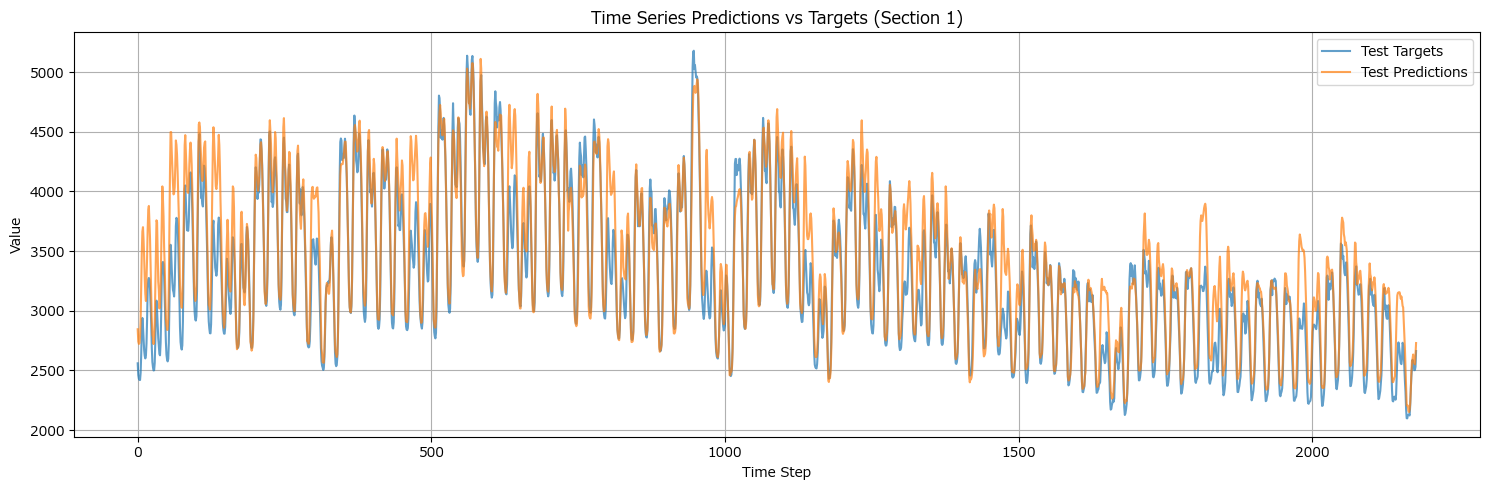

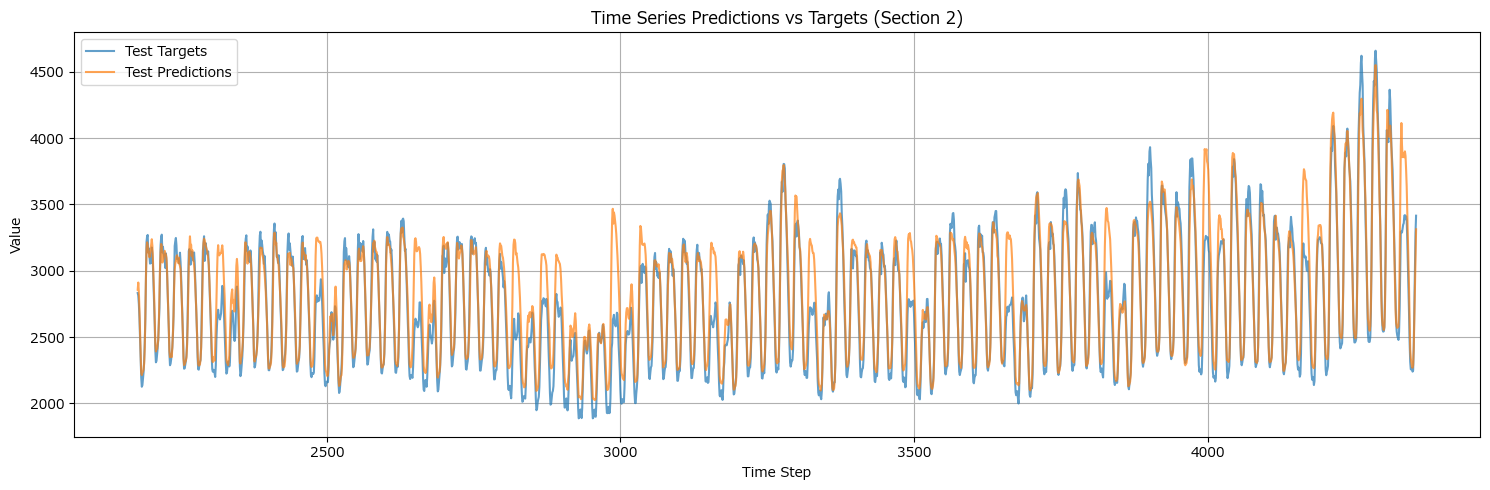

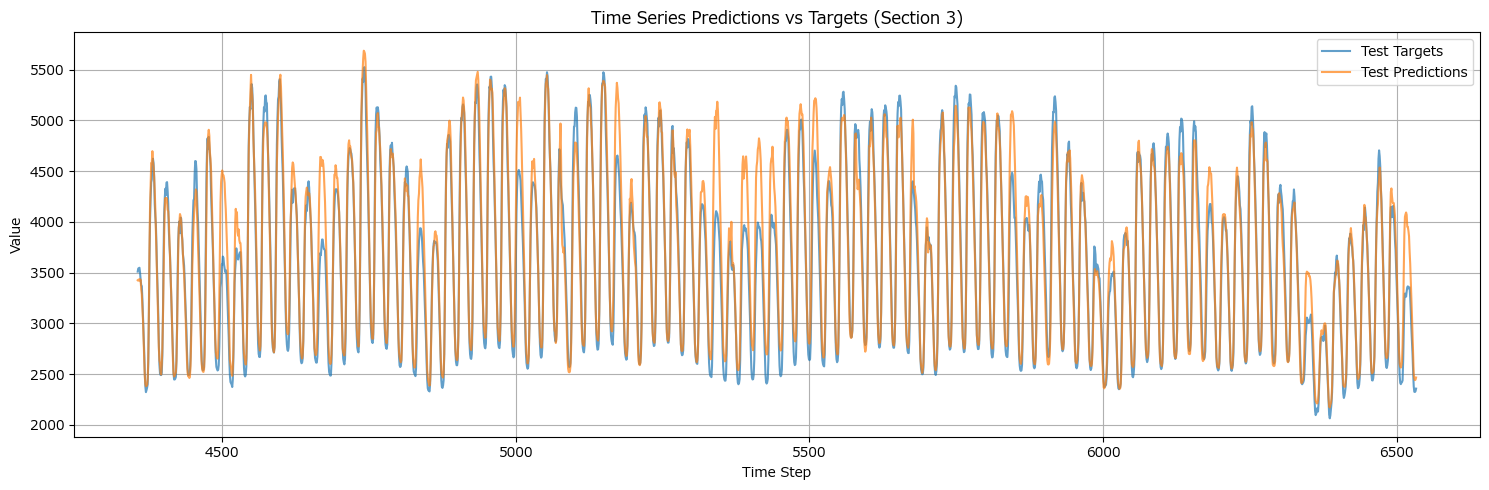

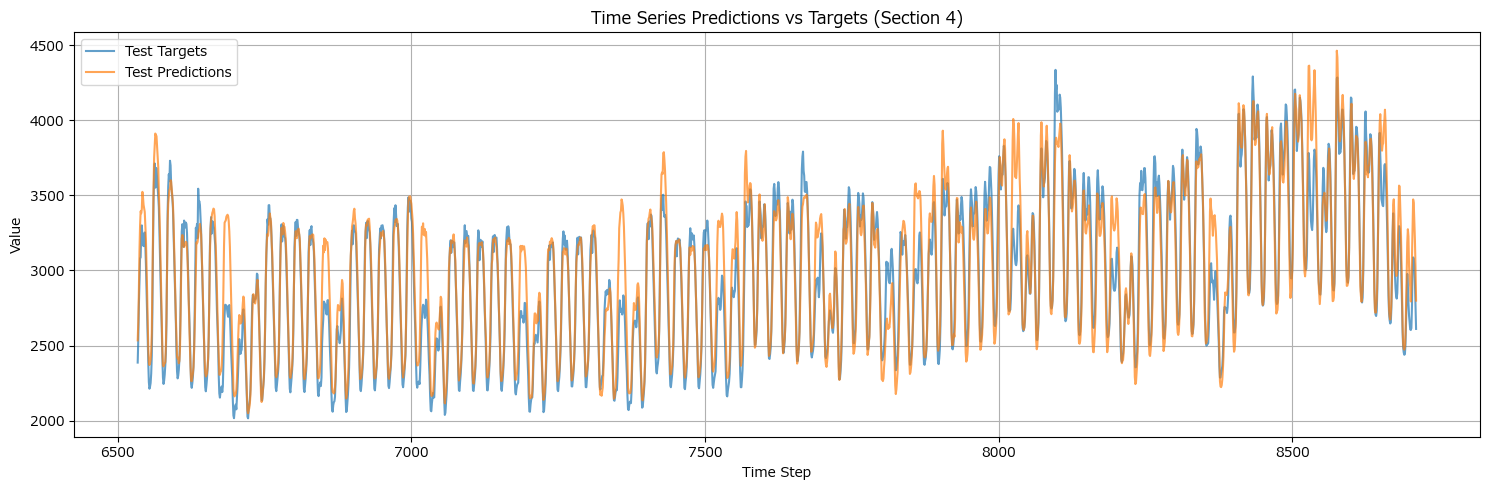

In [42]:
def plot_time_series_quarterly_timestep(test_targets, test_predictions):
    num_steps = len(test_targets)
    steps_per_section = num_steps // 4  # 4等分
    for i in range(4):
        start_idx = i * steps_per_section
        end_idx = start_idx + steps_per_section if i < 3 else num_steps  # 最後は余りを含む

        plt.figure(figsize=(15, 5))
        plt.plot(range(start_idx, end_idx), test_targets[start_idx:end_idx], label="Test Targets", alpha=0.7)
        plt.plot(range(start_idx, end_idx), test_predictions[start_idx:end_idx], label="Test Predictions", alpha=0.7)
        plt.legend()
        plt.title(f"Time Series Predictions vs Targets (Section {i+1})")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_time_series_quarterly_timestep(test_targets, test_predictions)

- Section1（1月～3月）：1月初旬に予測と実測値のズレが特に大きい。これは年始の特有な電力消費パターンや急激な気温変化が原因と考えられる。一方で、2月にもズレが見られるが、3月に入るとズレが徐々に小さくなる。冬の暖房需要が減少することが、ズレの縮小に寄与していると推測される。
- Section2（4月～6月）：4月から6月はズレが少なく、モデルがこの期間の電力消費を安定して予測できている。特に暖房の使用がほとんどないことが予測精度の向上に寄与していると考えられる。また、5月初旬（ゴールデンウィーク）の実測値が落ち着いているのは、連休中の家庭や企業活動の減少が要因と推測される。
- Section3（7月～9月）：7月から9月は電力消費の周期が大きくなり、需要が高まる日中の消費量をモデルは概ね正確に予測できている。一方で、8月中旬（お盆）の連休期間中に消費量が落ちる傾向があり、その期間に予測値が実測値を外している箇所が見られる。これはお盆特有の行動パターンが影響している可能性がある。
- Section4（10月～12月）：10月と11月は実測値より小さな周期で予測する傾向があり、11月中旬以降は実測値に対して一日の最大電力量を小さく予測するケースが増加している。これは暖房需要が急激に増加する時期であり、モデルがその変化を十分に反映できていないことが原因と考えられる。

- 次に、月ごとに実測値-予測値の残差がどのぐらいあるかを棒グラフおよび折れ線グラフで表す

#### 残差の可視化

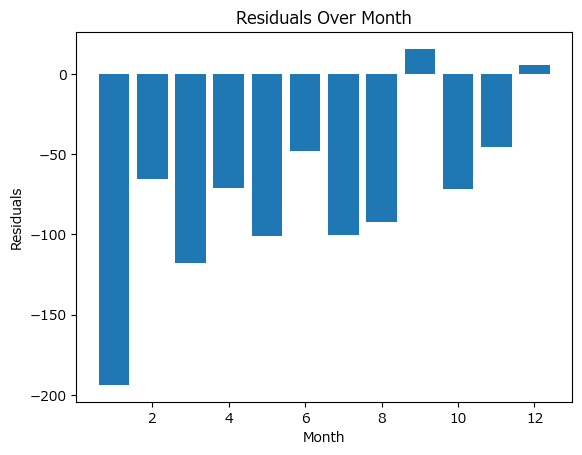

In [43]:
# 月ごとの残差の平均
result_df['diff'] = result_df['Actual'] - result_df['Prediction']
month_mean = pd.DataFrame(result_df.groupby('Month')['diff'].mean()).reset_index()
plt.bar(x=month_mean['Month'], height=month_mean['diff'])
plt.xlabel("Month")
plt.ylabel("Residuals")
plt.title("Residuals Over Month")
plt.show()

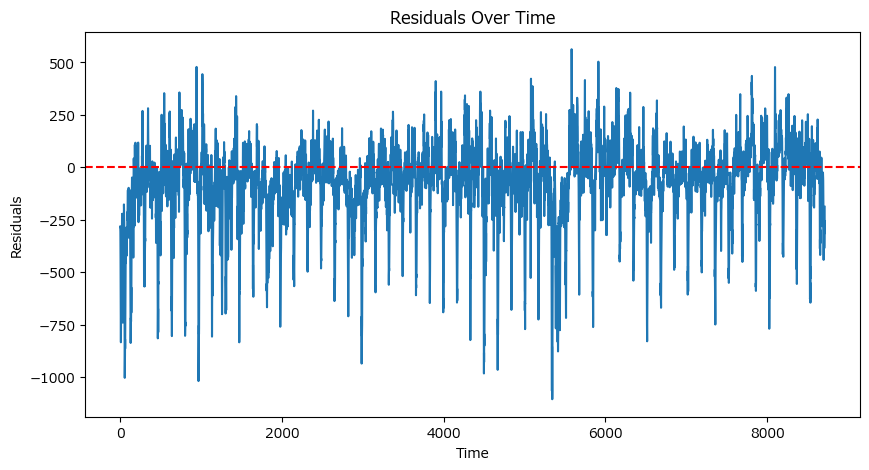

In [44]:
residuals = test_targets - test_predictions

plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residuals Over Time")
plt.show()

- 棒グラフより、全体を通して予測値のほうが実測値より大きく、特に一月に上振れが大きいことが分かる。
- また、折れ線グラフからは、若干の周期性が読み取られることから残差に季節要因がまだ含まれていることが分かる。

Mean of residuals: -74.5915
Standard deviation of residuals: 196.51886


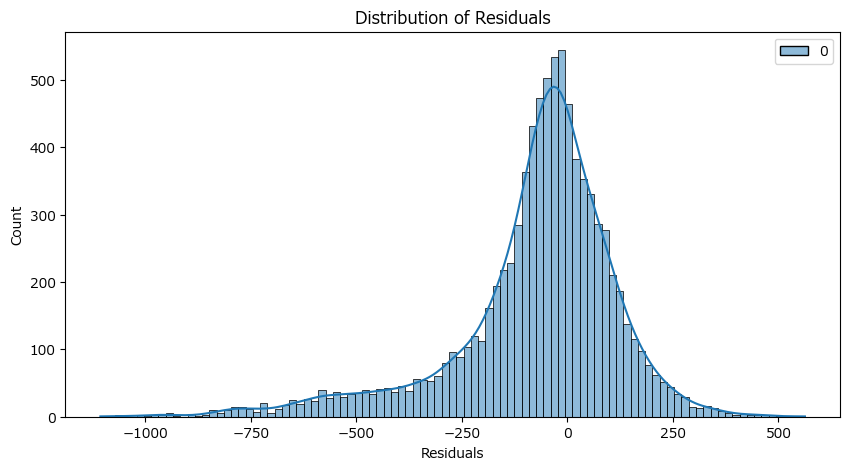

In [45]:
import seaborn as sns

print("Mean of residuals:", np.mean(residuals))
print("Standard deviation of residuals:", np.std(residuals))

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

- 残差のカーネル密度分布を確認し、左に裾が長くなったため、実際よりも大きく予測する傾向があることがここからも読み取れる。
- ここで前回のポートフォリオで最良のモデルであったProphet+LightGBMを使ったモデル（RMSE: 215.5838、R²: 0.9083）の結果とも比較してみると、残差の周期性が消えていることが分かる。

<left><img src="./imgs/Prophet_LightGBM.png" width=900px></left>

- 以上の考察により、残差について以下のとおりまとめたい。
    - 1月や8月中旬など、特定の期間で予測ズレが大きい理由として、休日特有の行動パターンや気温変動が影響している可能性が高い。
    - 4～6月のように、電力消費が安定している期間は高い予測精度を示しており、季節的要因の少ない時期はモデルが良好に機能している。
    - 冬季（11～12月）の暖房需要の急増については、モデルが十分に対応できていないため、追加の特徴量（例: 湿度や降水量）を考慮する必要がある。

#### 実測値と予測値の散布図

- 最後に、x軸に実測値、y軸に予測値を取った散布図を確認する

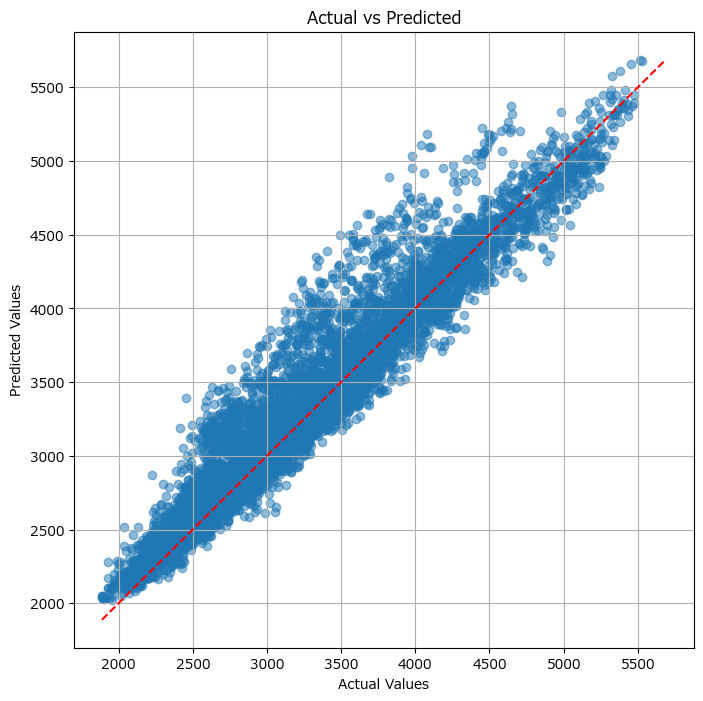

In [46]:
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_predictions, alpha=0.5)
plt.plot([test_targets.min(), test_predictions.max()], [test_targets.min(), test_predictions.max()], 'r--')  # 45度線
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

- 実測値より上振れする傾向は250万kWを超えたぐらいから見られ、だんだんと大きくなり、470万kWあたりでその傾向がなくなることが読み取れる。
- 前回までの深層学習を使わないモデルでは、実測値が400万kWを超えたあたりから大きく予測しすぎてしまう傾向があったが、今回の深層学習を使ったモデルでは、実測値が大きくなっても予測がうまくいっていることが分かる。

### 7.2 結論

- 本ポートフォリオでは、深層学習を使用して電力消費量を予測するモデルを構築し、前回までの深層学習を使用しないモデルよりも優れた予測精度を得ることができた。
- 試行したモデルとして、RNN、LSTM、GRUの3種類を比較した。GRUは基本性能において他の2つのモデルを上回り、さらにパラメータ調整を行った結果、最良の性能を示した。具体的には、学習率を0.002に変更したGRUで、決定係数0.913、平均平方根誤差210.199という結果を得た。また、バッチサイズを256に増加させた場合も同等の精度を示し、計算効率と性能のバランスにおいてGRUが他のモデルを上回ることが確認された。

- モデル比較
1. RNN:
    - 基本性能においてR2：0.8888、RMSE = 237.653 であり、精度の点でGRUおよびLSTMに劣った。
    - 最良のパラメータ調整として、隠れユニット数を64に変更し、RNN層を2層とした場合にR2：0.8960、RMSE = 229.855 となった。
    - 長期依存性を捉える能力に限界があり、計算効率を優先する場合にのみ有効。
2. LSTM:
    - デフォルト設定でR2：0.9059、RMSE：218.696 という性能を示した。
    - 構造の複雑さを上げた場合、性能向上が確認された。特に、隠れユニット数を256に増加し、出力層にドロップアウトを適用した場合にR2：0.9107、RMSE = 212.995 という結果を得た。ただし、計算時間がGRUに比べて長く、効率性の点で課題が残った。
3. GRU:
    - デフォルト設定でR2：0.9085、RMSE = 215.602 という性能を示し、RNNおよびLSTMを上回った。
    - 最良のパラメータ調整として、学習率を0.002に変更した場合にR2：0.9130、RMSE = 210.199 を達成した。
    - バッチサイズを256に増加させた場合にも同等の精度を示した。
    - 計算効率が高く、LSTMに比べて短い計算時間で高精度を実現。

- 残差分析と改善の方向性
    - 残差分析の結果、予測値が実測値を上回る傾向が確認された。この傾向は特に1月に顕著であり、以下の要因が影響している可能性がある：
        1. 休日特有の消費パターン（例: 大型連休期間である年末年始、GW、お盆）。
        2. 気温以外の気候要因（例: 湿度や降水量）。
    - これらの要因を反映した特徴量を追加することで、さらなる精度向上が期待できる。具体的には、気象データやイベント情報の活用が有効であると考えられる。

以上